In [31]:
%matplotlib inline

In [32]:
import os
import yaml
import shutil
from tqdm import tqdm
from datetime import datetime
import random
import numpy as np
import pandas as pd
import PIL.Image as Image
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

In [2]:
!pip install ultralytics

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [7]:
from ultralytics import YOLO
model = YOLO("yolov8l.pt")

In [8]:
!pip install roboflow

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [9]:
from roboflow import Roboflow

# dataset from https://universe.roboflow.com/great-barrier-reef/great-barrier-reef-o5scc
ROBOFLOW_API_KEY = "rWU1eQHaSgCK3DzRY2TP"
rf = Roboflow(api_key=ROBOFLOW_API_KEY)
project = rf.workspace("great-barrier-reef").project("great-barrier-reef-o5scc")
dataset = project.version(5).download("yolov8")

loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.1.34, to fix: `pip install ultralytics==8.0.196`



Extracting Dataset Version Zip to Great-Barrier-Reef-5 in yolov8:: 100%|██████████| 9838/9838 [00:06<00:00, 1601.72it/s]


In [8]:
HOME = os.getcwd()

In [9]:
# !mkdir datasets/ 
# !mv {HOME}/Great-Barrier-Reef-5 datasets/
if not os.path.exists("datasets"):
    os.mkdir("datasets")
    shutil.move(f"{HOME}/Great-Barrier-Reef-5", f"{HOME}/datasets")

In [10]:
# replace class 'json' to 'starfish' in data.yaml
DATASET_PATH = f'{HOME}/datasets/Great-Barrier-Reef-5/'

with open(DATASET_PATH + 'data.yaml', 'r') as f:
    data = yaml.safe_load(f)

data['names'] = ['starfish']
data['train'] = DATASET_PATH + 'train/images'
data['val'] = DATASET_PATH + 'valid/images'
data['test'] = DATASET_PATH +'test/images'

with open(DATASET_PATH + 'data.yaml', 'w') as file:
    yaml.dump(data, file, indent=4)

In [9]:
os.environ['WANDB_DISABLED'] = 'true'
os.environ['WANDB_MODE'] = 'disabled'

In [12]:
!pip install -U ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.4/214.4 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 63.6 MB/s eta 0:00:00:00:01
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.7
    Uninstalling widgetsnbextension-3.6.7:
      Successfully uninstalled widgetsnbextension-3.6.7
  Attempting uninstall: jupyterlab-widgets
    Found existing installation: jupyterlab-widgets 3.0.9
    Uninstalling jupyterlab-widgets-3.0.9:
      Successfully uninstalled jupyterlab-widgets-3.0.9
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


In [11]:
# Define the source and destination directories
source_image_dir = DATASET_PATH + 'train/images'
source_label_dir = DATASET_PATH + 'train/labels'
destination_image_dir = DATASET_PATH + 'sub_train/images'
destination_label_dir = DATASET_PATH + 'sub_train/labels'

# Create the destination directory if it does not exist
os.mkdir(DATASET_PATH + 'sub_train')
os.mkdir(destination_image_dir)
os.mkdir(destination_label_dir)

# List all files in the source directory
train_images = os.listdir(source_image_dir)

# Calculate the number of images to copy (3/4 of the total images)
num_images_to_copy = len(train_images) * 3 // 4

# Randomly select 3/4 of the images
images_to_copy = random.sample(train_images, num_images_to_copy)

# Copy the selected images to the destination directory
for image in images_to_copy:
    source_image_path = os.path.join(source_image_dir, image)
    source_label_path = source_image_path.replace("images", "labels").replace(".jpg", ".txt")
    
    destination_image_path = os.path.join(destination_image_dir, image)
    destination_label_path = destination_image_path.replace("images", "labels").replace(".jpg", ".txt")
    
    shutil.copy(source_image_path, destination_image_path)
    shutil.copy(source_label_path, destination_label_path)

In [12]:
# replace destination for training from "train" to 'sub_train' in data.yaml
DATASET_PATH = f'{HOME}/datasets/Great-Barrier-Reef-5/'

with open(DATASET_PATH + 'data.yaml', 'r') as f:
    data = yaml.safe_load(f)

data['train'] = DATASET_PATH + 'sub_train/images'

with open(DATASET_PATH + 'data.yaml', 'w') as file:
    yaml.dump(data, file, indent=4)

In [14]:
import optuna
import subprocess
import yaml
import os

# Define the objective function
def objective(trial):
    # Suggest hyperparameters
    learning_rate = trial.suggest_float('learning_rate', 0.0005, 0.05, log=True)
    momentum = trial.suggest_float("momentum", 0.7, 0.95)
    disabled_aug = {'augment': False,
                    'hsv_h': 0,
                    'hsv_s': 0,
                    'hsv_v': 0,
                    'degrees': 0,
                    'translate': 0,
                    'scale': 0,
                    'shear': 0,
                    'perspective': 0,
                    'flipud': 0,
                    'fliplr': 0,
                    'mosaic': 0,
                    'mixup': 0,
                    'erasing': 0.0,
                    'crop_fraction':0.0,
                   }
    
    
    model = YOLO("yolov8n.pt")    
        
    results = model.train(data=DATASET_PATH + 'data.yaml',
                            epochs=20,
                            plots=True,
                            imgsz=640,
                            batch=32,
                            lr0=learning_rate,
                            momentum=momentum,
                            optimizer="Adam",
                            patience=0,
                            **disabled_aug,
                            )
        
    metrics = model.val(data=DATASET_PATH + 'data.yaml')
    fitness = 0.2 * metrics.results_dict['metrics/recall(B)'] + 0.2 * metrics.results_dict['metrics/mAP50(B)'] + 0.6 * metrics.results_dict['metrics/mAP50-95(B)'] 
    val_loss = fitness # Run validation on a set specified as 'val' argument
    
    return val_loss

# Create a study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

# Get the best hyperparameters
print("Best hyperparameters: ", study.best_params)

[I 2024-08-15 12:21:31,632] A new study created in memory with name: no-name-45babefa-fbf9-4c0b-9398-fe86d293d05b


New https://pypi.org/project/ultralytics/8.2.77 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=h:\python_projects\deep_learning_technion\project\Starfish-Object-detection/datasets/Great-Barrier-Reef-5/data.yaml, epochs=20, time=None, patience=0, batch=32, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, vis

train: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\sub_train\labels.cache... 2578 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2578/2578 [00:00<?, ?it/s]
val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]


Plotting labels to runs\detect\train\labels.jpg... 
optimizer: Adam(lr=0.0016318254828494442, momentum=0.766988042779363) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs\detect\train
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/81 [00:00<?, ?it/s]c:\Users\Itai\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
       1/20      4.66G       2.48      3.443       1.61         36        640: 100%|██████████| 81/81 [00:40<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  94%|█████████▍| 15/16 [00:10<00:00,  1.51it/s]c:\Users\Itai\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPP

                   all        983       2479     0.0288      0.179     0.0429     0.0145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      4.66G      1.815      1.593      1.248         31        640: 100%|██████████| 81/81 [00:37<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.69it/s]

                   all        983       2479      0.501      0.253      0.281      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      4.63G      1.618      1.075      1.161         54        640: 100%|██████████| 81/81 [00:36<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.67it/s]

                   all        983       2479      0.369      0.252      0.228      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      4.63G      1.494      0.914       1.11         50        640: 100%|██████████| 81/81 [00:36<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.63it/s]


                   all        983       2479      0.569      0.386       0.42      0.206

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      4.63G      1.374     0.7759      1.065         31        640: 100%|██████████| 81/81 [00:36<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.62it/s]


                   all        983       2479      0.695      0.588      0.648      0.343

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      4.63G       1.28      0.688      1.029         46        640: 100%|██████████| 81/81 [00:36<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.66it/s]

                   all        983       2479      0.825      0.514      0.639      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      4.63G      1.194     0.6227     0.9994         65        640: 100%|██████████| 81/81 [00:36<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.64it/s]

                   all        983       2479      0.832      0.496      0.607      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      4.63G      1.102     0.5622     0.9654         53        640: 100%|██████████| 81/81 [00:37<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.60it/s]

                   all        983       2479      0.805      0.633      0.704      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      4.63G      1.015     0.5194     0.9343         42        640: 100%|██████████| 81/81 [00:37<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.63it/s]

                   all        983       2479      0.896      0.696       0.79      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      4.63G     0.9425     0.4862     0.9124         47        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.62it/s]

                   all        983       2479      0.865      0.763      0.822      0.464


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      4.63G      0.864     0.4457     0.8892         25        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.61it/s]

                   all        983       2479       0.96       0.74        0.8      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      4.63G     0.8009      0.422      0.872         38        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.63it/s]

                   all        983       2479      0.912      0.719      0.804      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      4.63G     0.7409     0.3933     0.8559         29        640: 100%|██████████| 81/81 [00:37<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.63it/s]

                   all        983       2479      0.951      0.769       0.83      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      4.63G     0.6763     0.3684      0.841         26        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.60it/s]

                   all        983       2479      0.956      0.776      0.847      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      4.63G     0.6084     0.3436     0.8266         50        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.60it/s]

                   all        983       2479      0.959      0.786       0.86      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      4.63G     0.5459     0.3214      0.814         27        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.61it/s]

                   all        983       2479      0.966      0.772      0.845      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      4.63G     0.5025     0.3038     0.8057         32        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.61it/s]

                   all        983       2479      0.952      0.806      0.867      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      4.63G      0.445     0.2828     0.7976         37        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        983       2479       0.95      0.791      0.862       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      4.63G     0.3901     0.2626     0.7906         40        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.61it/s]

                   all        983       2479      0.962      0.787      0.856       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      4.63G     0.3403     0.2441     0.7844         26        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.60it/s]

                   all        983       2479      0.962      0.794      0.864      0.547



20 epochs completed in 0.282 hours.
Optimizer stripped from runs\detect\train\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train\weights\best.pt, 6.2MB

Validating runs\detect\train\weights\best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.30it/s]


                   all        983       2479      0.962      0.794      0.863      0.547
Speed: 0.3ms preprocess, 3.4ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs\detect\train
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.44it/s]


                   all        983       2479      0.962      0.794      0.863      0.547
Speed: 0.3ms preprocess, 3.4ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs\detect\train2


[I 2024-08-15 12:40:50,171] Trial 0 finished with value: 0.659460907378211 and parameters: {'learning_rate': 0.0016318254828494442, 'momentum': 0.766988042779363}. Best is trial 0 with value: 0.659460907378211.


New https://pypi.org/project/ultralytics/8.2.77 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=h:\python_projects\deep_learning_technion\project\Starfish-Object-detection/datasets/Great-Barrier-Reef-5/data.yaml, epochs=20, time=None, patience=0, batch=32, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, vi

train: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\sub_train\labels.cache... 2578 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2578/2578 [00:00<?, ?it/s]
val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]


Plotting labels to runs\detect\train3\labels.jpg... 
optimizer: Adam(lr=0.009676156110529997, momentum=0.9210902256889096) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs\detect\train3
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      4.65G      2.467      3.306      1.612         36        640: 100%|██████████| 81/81 [00:38<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.37it/s]


                   all        983       2479      0.137       0.14     0.0559     0.0162

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      4.68G      1.953      2.007      1.336         31        640: 100%|██████████| 81/81 [00:38<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.45it/s]


                   all        983       2479      0.126      0.112     0.0513      0.019

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      4.63G      1.787      1.544      1.256         54        640: 100%|██████████| 81/81 [00:37<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.38it/s]


                   all        983       2479      0.131     0.0988     0.0427     0.0166

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      4.63G      1.677      1.279      1.205         50        640: 100%|██████████| 81/81 [00:37<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:14<00:00,  1.12it/s]


                   all        983       2479       0.24      0.168      0.125     0.0562

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      4.63G      1.562      1.049       1.15         31        640: 100%|██████████| 81/81 [00:37<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.51it/s]


                   all        983       2479      0.348      0.179      0.153      0.075

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      4.63G      1.489     0.9234      1.124         46        640: 100%|██████████| 81/81 [00:37<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.40it/s]


                   all        983       2479      0.292      0.387      0.273      0.118

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      4.63G      1.391     0.8207      1.086         65        640: 100%|██████████| 81/81 [00:38<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.48it/s]


                   all        983       2479      0.661      0.473      0.512      0.239

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      4.63G       1.33      0.721       1.06         53        640: 100%|██████████| 81/81 [00:37<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.45it/s]


                   all        983       2479      0.597      0.488       0.51      0.272

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      4.63G      1.264     0.6815      1.033         42        640: 100%|██████████| 81/81 [00:37<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.48it/s]

                   all        983       2479       0.76      0.568      0.653      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      4.63G      1.196     0.6246      1.008         47        640: 100%|██████████| 81/81 [00:38<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.43it/s]


                   all        983       2479      0.701      0.628      0.684      0.373
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      4.63G      1.122     0.5846     0.9822         25        640: 100%|██████████| 81/81 [00:38<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.43it/s]

                   all        983       2479      0.764       0.66      0.737      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      4.63G      1.045     0.5374     0.9556         38        640: 100%|██████████| 81/81 [00:37<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.50it/s]

                   all        983       2479      0.731       0.38      0.449      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      4.63G     0.9748     0.4992     0.9333         29        640: 100%|██████████| 81/81 [00:37<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.49it/s]

                   all        983       2479      0.675      0.511      0.617      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      4.63G     0.9316     0.4743     0.9188         26        640: 100%|██████████| 81/81 [00:38<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.48it/s]

                   all        983       2479      0.842      0.775      0.828      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      4.63G      0.874     0.4442     0.9027         50        640: 100%|██████████| 81/81 [00:37<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.46it/s]

                   all        983       2479      0.638      0.497      0.565      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      4.63G     0.7982     0.4091     0.8819         27        640: 100%|██████████| 81/81 [00:38<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.47it/s]

                   all        983       2479      0.912       0.77      0.866      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      4.63G     0.7458     0.3897     0.8666         32        640: 100%|██████████| 81/81 [00:37<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.47it/s]

                   all        983       2479      0.692      0.662      0.718      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      4.63G     0.6772     0.3614      0.851         37        640: 100%|██████████| 81/81 [00:38<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.48it/s]

                   all        983       2479       0.91        0.8      0.884      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      4.63G     0.6024     0.3321     0.8345         40        640: 100%|██████████| 81/81 [00:38<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.47it/s]

                   all        983       2479      0.841       0.75      0.819       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      4.63G     0.5383     0.3082     0.8217         26        640: 100%|██████████| 81/81 [00:38<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.47it/s]

                   all        983       2479       0.83      0.727      0.802      0.504



20 epochs completed in 0.296 hours.
Optimizer stripped from runs\detect\train3\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train3\weights\best.pt, 6.2MB

Validating runs\detect\train3\weights\best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:13<00:00,  1.18it/s]


                   all        983       2479      0.908        0.8      0.884      0.541
Speed: 0.3ms preprocess, 3.4ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs\detect\train3
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:14<00:00,  2.13it/s]


                   all        983       2479      0.908        0.8      0.884      0.541
Speed: 0.3ms preprocess, 3.4ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs\detect\train32


[I 2024-08-15 13:02:04,852] Trial 1 finished with value: 0.6611170491652485 and parameters: {'learning_rate': 0.009676156110529997, 'momentum': 0.9210902256889096}. Best is trial 1 with value: 0.6611170491652485.


New https://pypi.org/project/ultralytics/8.2.77 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=h:\python_projects\deep_learning_technion\project\Starfish-Object-detection/datasets/Great-Barrier-Reef-5/data.yaml, epochs=20, time=None, patience=0, batch=32, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, vi

train: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\sub_train\labels.cache... 2578 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2578/2578 [00:00<?, ?it/s]
val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]


Plotting labels to runs\detect\train4\labels.jpg... 
optimizer: Adam(lr=0.029043537615770592, momentum=0.7088433068527431) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs\detect\train4
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20       4.7G       2.62      3.512      1.688         36        640: 100%|██████████| 81/81 [00:38<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:14<00:00,  1.10it/s]


                   all        983       2479   5.09e-05    0.00605   2.56e-05   6.48e-06

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      4.69G      2.271        2.7      1.492         31        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.42it/s]


                   all        983       2479     0.0191     0.0871    0.00829    0.00333

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      4.65G      2.154      2.395      1.431         54        640: 100%|██████████| 81/81 [00:36<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:13<00:00,  1.16it/s]


                   all        983       2479     0.0526     0.0613      0.029      0.012

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      4.64G      2.025      2.136      1.378         50        640: 100%|██████████| 81/81 [00:36<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.25it/s]


                   all        983       2479   0.000269    0.00726   7.37e-05   2.26e-05

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      4.63G      1.895      1.782      1.305         31        640: 100%|██████████| 81/81 [00:36<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.52it/s]


                   all        983       2479      0.272      0.171      0.135     0.0663

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      4.63G      1.767      1.543      1.245         46        640: 100%|██████████| 81/81 [00:36<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.65it/s]

                   all        983       2479     0.0901     0.0311      0.015    0.00546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      4.63G      1.676      1.293      1.202         65        640: 100%|██████████| 81/81 [00:36<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.60it/s]


                   all        983       2479      0.701      0.305      0.338      0.159

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      4.63G      1.571      1.102      1.159         53        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]


                   all        983       2479      0.547      0.417      0.428      0.203

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      4.63G      1.501     0.9736      1.126         42        640: 100%|██████████| 81/81 [00:37<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]


                   all        983       2479      0.531      0.346       0.35      0.176

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      4.63G      1.444     0.8888      1.103         47        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.60it/s]


                   all        983       2479      0.617      0.442      0.474      0.245
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      4.63G      1.367     0.8114      1.074         25        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]


                   all        983       2479      0.695      0.476      0.502      0.262

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      4.63G      1.312     0.7474      1.052         38        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

                   all        983       2479      0.741      0.564       0.65      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      4.63G      1.237     0.6759      1.024         29        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.62it/s]

                   all        983       2479      0.903      0.438      0.525      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      4.63G      1.179     0.6304      1.003         26        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.63it/s]

                   all        983       2479       0.62      0.356      0.402      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      4.63G      1.101     0.5764     0.9783         50        640: 100%|██████████| 81/81 [00:37<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

                   all        983       2479      0.869      0.684      0.771       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      4.63G      1.042     0.5472     0.9588         27        640: 100%|██████████| 81/81 [00:37<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.61it/s]

                   all        983       2479      0.877      0.642      0.755      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      4.63G     0.9815     0.5017     0.9388         32        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

                   all        983       2479       0.87      0.626      0.714      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      4.63G     0.8987     0.4627     0.9167         37        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        983       2479      0.913        0.6      0.713      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      4.63G     0.8233     0.4261     0.8947         40        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.61it/s]

                   all        983       2479      0.978      0.545      0.648      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      4.63G     0.7538      0.396      0.877         26        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.60it/s]

                   all        983       2479      0.927      0.572      0.674      0.412



20 epochs completed in 0.302 hours.
Optimizer stripped from runs\detect\train4\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train4\weights\best.pt, 6.2MB

Validating runs\detect\train4\weights\best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.29it/s]


                   all        983       2479      0.869      0.685      0.771       0.44
Speed: 0.3ms preprocess, 3.4ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs\detect\train4
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.46it/s]


                   all        983       2479      0.869      0.685      0.771       0.44
Speed: 0.3ms preprocess, 3.4ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs\detect\train42


[I 2024-08-15 13:22:36,003] Trial 2 finished with value: 0.5550056287574485 and parameters: {'learning_rate': 0.029043537615770592, 'momentum': 0.7088433068527431}. Best is trial 1 with value: 0.6611170491652485.


New https://pypi.org/project/ultralytics/8.2.77 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=h:\python_projects\deep_learning_technion\project\Starfish-Object-detection/datasets/Great-Barrier-Reef-5/data.yaml, epochs=20, time=None, patience=0, batch=32, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, vi

train: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\sub_train\labels.cache... 2578 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2578/2578 [00:00<?, ?it/s]
val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]


Plotting labels to runs\detect\train5\labels.jpg... 
optimizer: Adam(lr=0.000575267742847012, momentum=0.915248467568964) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs\detect\train5
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      4.66G      2.597      3.833      1.682         36        640: 100%|██████████| 81/81 [00:37<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.27it/s]

                   all        983       2479     0.0286   0.000403     0.0146    0.00438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      4.67G      1.883      1.952      1.286         31        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.68it/s]

                   all        983       2479      0.774     0.0984      0.217      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      4.63G      1.648      1.226      1.174         54        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.64it/s]

                   all        983       2479      0.688      0.385      0.457      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      4.63G      1.478     0.9298      1.103         50        640: 100%|██████████| 81/81 [00:37<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.63it/s]

                   all        983       2479      0.658      0.466       0.52      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      4.63G      1.306     0.7539      1.035         31        640: 100%|██████████| 81/81 [00:36<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.62it/s]

                   all        983       2479      0.767      0.519       0.61       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      4.63G      1.208     0.6689     0.9987         46        640: 100%|██████████| 81/81 [00:37<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.60it/s]

                   all        983       2479      0.778      0.545      0.661      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      4.63G      1.095     0.6024     0.9605         65        640: 100%|██████████| 81/81 [00:37<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.61it/s]

                   all        983       2479      0.813      0.702      0.782       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      4.63G      1.003     0.5391     0.9304         53        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.63it/s]

                   all        983       2479      0.848      0.621      0.753       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      4.63G     0.9348     0.5067      0.907         42        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.62it/s]

                   all        983       2479       0.84      0.655      0.768      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      4.63G     0.8506     0.4644     0.8841         47        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        983       2479      0.858       0.76      0.831      0.472


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      4.63G     0.7895     0.4381      0.868         25        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.63it/s]

                   all        983       2479      0.893      0.751       0.85      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      4.63G     0.7371     0.4173     0.8543         38        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.60it/s]

                   all        983       2479      0.897      0.811       0.89      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      4.63G     0.6662     0.3858     0.8373         29        640: 100%|██████████| 81/81 [00:37<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.63it/s]

                   all        983       2479      0.917      0.794      0.881      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      4.63G     0.6162     0.3655     0.8271         26        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.61it/s]

                   all        983       2479      0.913      0.807      0.891      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      4.63G     0.5656     0.3453     0.8182         50        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.61it/s]

                   all        983       2479      0.908      0.805      0.895      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      4.63G     0.5295      0.331     0.8102         27        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

                   all        983       2479      0.924      0.814      0.902      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      4.63G     0.4767      0.309     0.8021         32        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.63it/s]

                   all        983       2479      0.929      0.818      0.908      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      4.63G     0.4255       0.29     0.7955         37        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.62it/s]

                   all        983       2479      0.939      0.812      0.912      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      4.63G     0.3781     0.2736     0.7899         40        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.63it/s]

                   all        983       2479      0.936      0.811      0.912      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      4.63G     0.3447     0.2601     0.7859         26        640: 100%|██████████| 81/81 [00:37<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.60it/s]

                   all        983       2479      0.917      0.831      0.916      0.575



20 epochs completed in 0.281 hours.
Optimizer stripped from runs\detect\train5\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train5\weights\best.pt, 6.2MB

Validating runs\detect\train5\weights\best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.31it/s]


                   all        983       2479      0.918      0.833      0.916      0.575
Speed: 0.3ms preprocess, 3.4ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs\detect\train5
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.45it/s]


                   all        983       2479      0.918      0.833      0.916      0.575
Speed: 0.3ms preprocess, 3.4ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs\detect\train52


[I 2024-08-15 13:42:46,388] Trial 3 finished with value: 0.6950534174924061 and parameters: {'learning_rate': 0.000575267742847012, 'momentum': 0.915248467568964}. Best is trial 3 with value: 0.6950534174924061.


New https://pypi.org/project/ultralytics/8.2.77 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=h:\python_projects\deep_learning_technion\project\Starfish-Object-detection/datasets/Great-Barrier-Reef-5/data.yaml, epochs=20, time=None, patience=0, batch=32, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train6, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, vi

train: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\sub_train\labels.cache... 2578 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2578/2578 [00:00<?, ?it/s]
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x00000267643C8400>
Traceback (most recent call last):
  File "c:\Users\Itai\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "c:\Users\Itai\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py", line 1425, in _shutdown_workers
    self._pin_memory_thread.join()
  File "c:\Users\Itai\AppData\Local\Programs\Python\Python312\Lib\threading.py", line 1144, in join
    raise RuntimeError("cannot join current thread")
RuntimeError: cannot join current thread
val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Gre

Plotting labels to runs\detect\train6\labels.jpg... 
optimizer: Adam(lr=0.03138493437010784, momentum=0.9140571177927448) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs\detect\train6
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      4.64G       2.55      3.403      1.645         36        640: 100%|██████████| 81/81 [00:38<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.22it/s]

                   all        983       2479          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      4.68G      2.129      2.427      1.422         31        640: 100%|██████████| 81/81 [00:37<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:13<00:00,  1.15it/s]


                   all        983       2479    0.00487     0.0226    0.00116   0.000417

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      4.63G      2.019      2.173      1.369         54        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.33it/s]


                   all        983       2479        0.1      0.142     0.0521     0.0195

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      4.63G       1.91      1.918      1.317         50        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.48it/s]


                   all        983       2479     0.0343     0.0476     0.0104    0.00437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      4.62G      1.813      1.657      1.271         31        640: 100%|██████████| 81/81 [00:37<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.63it/s]

                   all        983       2479      0.144     0.0589     0.0269     0.0123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      4.62G      1.691      1.404      1.215         46        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.61it/s]


                   all        983       2479      0.308      0.199      0.175     0.0734

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      4.62G      1.653      1.254      1.194         65        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]


                   all        983       2479       0.24      0.192      0.122     0.0492

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      4.63G      1.547      1.068      1.151         53        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]


                   all        983       2479       0.38      0.194      0.182     0.0891

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      4.62G      1.486     0.9691      1.121         42        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.53it/s]


                   all        983       2479      0.574      0.449      0.454      0.235

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      4.63G      1.446     0.8903      1.105         47        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]


                   all        983       2479      0.447      0.342      0.321       0.15
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      4.62G      1.369     0.8156      1.075         25        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.54it/s]


                   all        983       2479      0.808      0.495      0.541       0.29

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      4.63G      1.282     0.7366       1.04         38        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.60it/s]

                   all        983       2479      0.733      0.509      0.585      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      4.62G      1.232     0.6744       1.02         29        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]


                   all        983       2479       0.76      0.588      0.651      0.357

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      4.63G      1.174     0.6398      1.002         26        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.61it/s]

                   all        983       2479      0.826      0.409      0.498       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      4.62G      1.152     0.6153     0.9919         50        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.54it/s]

                   all        983       2479      0.826      0.491      0.577       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      4.62G      1.053     0.5485     0.9631         27        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

                   all        983       2479      0.891      0.633       0.72      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      4.62G      1.004     0.5197     0.9466         32        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.61it/s]

                   all        983       2479      0.803      0.522      0.629      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      4.62G     0.9228     0.4773     0.9222         37        640: 100%|██████████| 81/81 [00:37<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.61it/s]

                   all        983       2479      0.853       0.61      0.708        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      4.62G     0.8486     0.4392     0.9027         40        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        983       2479      0.847       0.54      0.633      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      4.62G      0.774      0.406     0.8838         26        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.61it/s]

                   all        983       2479      0.912      0.546      0.676       0.42



20 epochs completed in 0.284 hours.
Optimizer stripped from runs\detect\train6\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train6\weights\best.pt, 6.2MB

Validating runs\detect\train6\weights\best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.28it/s]


                   all        983       2479      0.912      0.546      0.676       0.42
Speed: 0.3ms preprocess, 3.4ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs\detect\train6
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.45it/s]


                   all        983       2479      0.912      0.546      0.676       0.42
Speed: 0.4ms preprocess, 3.4ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs\detect\train62


[I 2024-08-15 14:02:10,175] Trial 4 finished with value: 0.49664124002681664 and parameters: {'learning_rate': 0.03138493437010784, 'momentum': 0.9140571177927448}. Best is trial 3 with value: 0.6950534174924061.


New https://pypi.org/project/ultralytics/8.2.77 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=h:\python_projects\deep_learning_technion\project\Starfish-Object-detection/datasets/Great-Barrier-Reef-5/data.yaml, epochs=20, time=None, patience=0, batch=32, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train7, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, vi

train: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\sub_train\labels.cache... 2578 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2578/2578 [00:00<?, ?it/s]
val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]


Plotting labels to runs\detect\train7\labels.jpg... 
optimizer: Adam(lr=0.002483809600239961, momentum=0.890344431802912) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs\detect\train7
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      4.71G      2.495      3.408       1.64         36        640: 100%|██████████| 81/81 [00:37<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.72it/s]

                   all        983       2479      0.014      0.244     0.0391     0.0149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      4.68G      1.825       1.61      1.268         31        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.70it/s]

                   all        983       2479      0.356     0.0522     0.0642     0.0299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      4.65G      1.639      1.117      1.174         54        640: 100%|██████████| 81/81 [00:36<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.51it/s]


                   all        983       2479        0.4      0.338       0.26      0.114

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      4.67G      1.518     0.9516      1.125         50        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.50it/s]


                   all        983       2479      0.332      0.251      0.219      0.102

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      4.63G      1.393     0.7996      1.075         31        640: 100%|██████████| 81/81 [00:37<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]


                   all        983       2479      0.422      0.447      0.394      0.194

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      4.63G      1.312     0.7257      1.046         46        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.61it/s]

                   all        983       2479       0.75      0.599      0.673      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      4.62G      1.225     0.6381      1.015         65        640: 100%|██████████| 81/81 [00:37<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        983       2479      0.515      0.381      0.393      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      4.62G      1.159      0.588     0.9894         53        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.61it/s]

                   all        983       2479      0.855      0.718      0.799       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      4.62G      1.058     0.5412     0.9502         42        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.62it/s]

                   all        983       2479      0.855      0.644       0.74      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      4.62G     0.9898      0.501     0.9287         47        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.61it/s]

                   all        983       2479      0.909      0.628      0.727      0.412


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      4.62G     0.9258      0.466     0.9081         25        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.61it/s]

                   all        983       2479      0.875      0.778      0.867       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      4.62G     0.8585     0.4398     0.8877         38        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.62it/s]

                   all        983       2479      0.874      0.754      0.842      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      4.62G     0.7778     0.4128     0.8676         29        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.56it/s]

                   all        983       2479      0.882      0.751      0.825      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      4.62G     0.7248     0.3876     0.8542         26        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.62it/s]

                   all        983       2479      0.923      0.803      0.891      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      4.62G     0.6657     0.3648     0.8409         50        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.61it/s]

                   all        983       2479       0.93      0.832      0.911      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      4.62G     0.6073     0.3452     0.8267         27        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.62it/s]

                   all        983       2479      0.946      0.838      0.914      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      4.62G      0.545     0.3188     0.8146         32        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        983       2479      0.943      0.846       0.91      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      4.62G     0.4889     0.2989     0.8063         37        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

                   all        983       2479      0.937      0.848      0.906      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      4.62G     0.4239     0.2762     0.7963         40        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

                   all        983       2479       0.94      0.873      0.925      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      4.62G     0.3685     0.2557     0.7891         26        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

                   all        983       2479      0.947      0.869      0.918      0.583



20 epochs completed in 0.299 hours.
Optimizer stripped from runs\detect\train7\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train7\weights\best.pt, 6.2MB

Validating runs\detect\train7\weights\best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.28it/s]


                   all        983       2479       0.94      0.872      0.924      0.583
Speed: 0.4ms preprocess, 3.4ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs\detect\train7
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.40it/s]


                   all        983       2479       0.94      0.872      0.924      0.583
Speed: 0.4ms preprocess, 3.4ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs\detect\train72


[I 2024-08-15 14:22:28,925] Trial 5 finished with value: 0.7089651967195023 and parameters: {'learning_rate': 0.002483809600239961, 'momentum': 0.890344431802912}. Best is trial 5 with value: 0.7089651967195023.


New https://pypi.org/project/ultralytics/8.2.77 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=h:\python_projects\deep_learning_technion\project\Starfish-Object-detection/datasets/Great-Barrier-Reef-5/data.yaml, epochs=20, time=None, patience=0, batch=32, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train8, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, vi

train: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\sub_train\labels.cache... 2578 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2578/2578 [00:00<?, ?it/s]
val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]


Plotting labels to runs\detect\train8\labels.jpg... 
optimizer: Adam(lr=0.011289687515659109, momentum=0.887646318972832) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs\detect\train8
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      4.64G      2.476      3.301      1.621         36        640: 100%|██████████| 81/81 [00:37<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:13<00:00,  1.22it/s]


                   all        983       2479    0.00496     0.0593    0.00221   0.000525

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      4.69G      1.985      2.064      1.353         31        640: 100%|██████████| 81/81 [00:37<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.62it/s]


                   all        983       2479      0.184      0.115     0.0616     0.0253

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      4.66G      1.826      1.623       1.27         54        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]


                   all        983       2479     0.0121     0.0577     0.0037    0.00118

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      4.64G      1.705      1.373      1.213         50        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.61it/s]


                   all        983       2479     0.0422     0.0226     0.0088    0.00335

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      4.63G      1.616      1.124      1.171         31        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.56it/s]


                   all        983       2479      0.344       0.38      0.255      0.111

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      4.63G       1.51     0.9493      1.127         46        640: 100%|██████████| 81/81 [00:37<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.54it/s]


                   all        983       2479      0.133      0.151      0.069     0.0263

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      4.63G      1.427     0.8545      1.096         65        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

                   all        983       2479      0.643      0.231      0.255      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      4.63G      1.339     0.7251      1.062         53        640: 100%|██████████| 81/81 [00:37<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        983       2479      0.682      0.607      0.615      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      4.63G      1.271     0.6826      1.036         42        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        983       2479      0.753      0.533      0.645      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      4.63G      1.205     0.6302      1.009         47        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

                   all        983       2479      0.484      0.354      0.389      0.203


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      4.63G      1.125     0.5791     0.9848         25        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]


                   all        983       2479      0.721      0.537      0.606      0.338

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      4.63G      1.067      0.552     0.9639         38        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.61it/s]

                   all        983       2479      0.855      0.684      0.788      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      4.63G          1     0.5048     0.9396         29        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        983       2479      0.816       0.67      0.769      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      4.63G     0.9378     0.4781     0.9217         26        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

                   all        983       2479      0.892      0.722      0.825      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      4.63G     0.8781     0.4459     0.9035         50        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

                   all        983       2479      0.888      0.743      0.844      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      4.63G     0.8094     0.4201     0.8862         27        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

                   all        983       2479      0.831      0.685       0.79      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      4.63G     0.7533     0.3946     0.8687         32        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

                   all        983       2479      0.771      0.722      0.768       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      4.63G      0.685     0.3693     0.8539         37        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        983       2479      0.875      0.798      0.865      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      4.63G     0.6134     0.3429     0.8375         40        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        983       2479      0.811      0.739      0.807      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      4.63G       0.54      0.316     0.8229         26        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.61it/s]

                   all        983       2479      0.888      0.773       0.85      0.531



20 epochs completed in 0.284 hours.
Optimizer stripped from runs\detect\train8\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train8\weights\best.pt, 6.2MB

Validating runs\detect\train8\weights\best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.26it/s]


                   all        983       2479      0.875      0.799      0.865      0.535
Speed: 0.3ms preprocess, 3.4ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs\detect\train8
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.40it/s]


                   all        983       2479      0.875      0.799      0.865      0.535
Speed: 0.3ms preprocess, 3.4ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs\detect\train82


[I 2024-08-15 14:42:50,788] Trial 6 finished with value: 0.6540948480812127 and parameters: {'learning_rate': 0.011289687515659109, 'momentum': 0.887646318972832}. Best is trial 5 with value: 0.7089651967195023.


New https://pypi.org/project/ultralytics/8.2.77 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=h:\python_projects\deep_learning_technion\project\Starfish-Object-detection/datasets/Great-Barrier-Reef-5/data.yaml, epochs=20, time=None, patience=0, batch=32, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train9, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, vi

train: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\sub_train\labels.cache... 2578 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2578/2578 [00:00<?, ?it/s]
val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]


Plotting labels to runs\detect\train9\labels.jpg... 
optimizer: Adam(lr=0.0009426425935517761, momentum=0.813963335020954) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs\detect\train9
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      4.65G      2.522      3.573      1.635         36        640: 100%|██████████| 81/81 [00:38<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.88it/s]

                   all        983       2479      0.135     0.0992     0.0911     0.0354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      4.68G      1.827      1.664      1.253         31        640: 100%|██████████| 81/81 [00:37<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.66it/s]

                   all        983       2479      0.422      0.184      0.193     0.0901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      4.63G      1.598      1.089      1.147         54        640: 100%|██████████| 81/81 [00:36<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.64it/s]

                   all        983       2479      0.577      0.415      0.449      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      4.63G      1.461     0.8825      1.091         50        640: 100%|██████████| 81/81 [00:37<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.61it/s]

                   all        983       2479       0.69      0.452       0.52      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      4.63G      1.333     0.7426      1.044         31        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

                   all        983       2479      0.737      0.582      0.658      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      4.63G       1.22     0.6487      1.001         46        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.60it/s]

                   all        983       2479      0.819      0.633      0.732      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      4.63G      1.145     0.5993      0.977         65        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

                   all        983       2479      0.831      0.726      0.803      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      4.63G      1.038     0.5393     0.9418         53        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.52it/s]

                   all        983       2479      0.867      0.719      0.812      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      4.63G     0.9601     0.4998     0.9142         42        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

                   all        983       2479      0.909      0.721      0.802      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      4.63G     0.8914     0.4631     0.8935         47        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.60it/s]

                   all        983       2479      0.899      0.762      0.852      0.495


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      4.63G     0.8069     0.4292      0.872         25        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.60it/s]

                   all        983       2479      0.941      0.739      0.812       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      4.63G     0.7595     0.4075     0.8591         38        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.62it/s]

                   all        983       2479      0.917      0.806      0.901      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      4.63G     0.6876      0.378     0.8422         29        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

                   all        983       2479       0.91       0.82       0.89      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      4.63G     0.6329     0.3567     0.8306         26        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.61it/s]

                   all        983       2479      0.922      0.833      0.893      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      4.63G     0.5756     0.3369     0.8194         50        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.61it/s]

                   all        983       2479      0.924      0.822       0.89      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      4.63G     0.5205     0.3145     0.8083         27        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.60it/s]

                   all        983       2479      0.928      0.818      0.881       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      4.63G     0.4738     0.2962      0.801         32        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        983       2479      0.955       0.83      0.908      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      4.63G     0.4112     0.2743      0.793         37        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.47it/s]

                   all        983       2479      0.935      0.864      0.913      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      4.63G     0.3701     0.2578     0.7877         40        640: 100%|██████████| 81/81 [00:38<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.47it/s]

                   all        983       2479       0.95      0.844      0.909      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      4.63G     0.3265     0.2415     0.7824         26        640: 100%|██████████| 81/81 [00:39<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.25it/s]

                   all        983       2479      0.936      0.864      0.917      0.581



20 epochs completed in 0.284 hours.
Optimizer stripped from runs\detect\train9\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train9\weights\best.pt, 6.2MB

Validating runs\detect\train9\weights\best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:15<00:00,  1.06it/s]


                   all        983       2479      0.936      0.864      0.917      0.581
Speed: 0.4ms preprocess, 3.6ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs\detect\train9
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:13<00:00,  2.22it/s]


                   all        983       2479      0.936      0.864      0.917      0.581
Speed: 0.4ms preprocess, 3.7ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs\detect\train92


[I 2024-08-15 15:03:20,905] Trial 7 finished with value: 0.7045669517020148 and parameters: {'learning_rate': 0.0009426425935517761, 'momentum': 0.813963335020954}. Best is trial 5 with value: 0.7089651967195023.


New https://pypi.org/project/ultralytics/8.2.77 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=h:\python_projects\deep_learning_technion\project\Starfish-Object-detection/datasets/Great-Barrier-Reef-5/data.yaml, epochs=20, time=None, patience=0, batch=32, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train10, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, v

train: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\sub_train\labels.cache... 2578 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2578/2578 [00:00<?, ?it/s]
val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]


Plotting labels to runs\detect\train10\labels.jpg... 
optimizer: Adam(lr=0.020735601581391278, momentum=0.8018619360334129) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs\detect\train10
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      4.71G       2.54        3.4       1.65         36        640: 100%|██████████| 81/81 [00:38<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


                   all        983       2479    0.00199      0.237    0.00147   0.000445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      4.69G      2.132      2.379      1.421         31        640: 100%|██████████| 81/81 [00:37<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.54it/s]


                   all        983       2479      0.071     0.0214    0.00907     0.0043

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      4.66G      1.979      1.998      1.341         54        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.29it/s]


                   all        983       2479     0.0107     0.0331    0.00475    0.00137

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      4.67G       1.87      1.726      1.291         50        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.50it/s]


                   all        983       2479      0.102     0.0662     0.0281     0.0118

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      4.63G      1.723      1.429      1.224         31        640: 100%|██████████| 81/81 [00:37<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.56it/s]


                   all        983       2479      0.324      0.212      0.177     0.0796

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      4.63G      1.624      1.208      1.181         46        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.52it/s]


                   all        983       2479    0.00418      0.378    0.00283    0.00126

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      4.63G      1.544      1.052      1.145         65        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.55it/s]


                   all        983       2479      0.579      0.268      0.273      0.128

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      4.63G      1.475     0.8979      1.116         53        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.54it/s]


                   all        983       2479      0.657      0.532      0.584       0.29

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      4.63G      1.393     0.8332      1.081         42        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.56it/s]

                   all        983       2479      0.371      0.217      0.205     0.0943



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      4.63G      1.321     0.7489      1.052         47        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.56it/s]

                   all        983       2479      0.816      0.593      0.702      0.373


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      4.63G      1.261     0.6837      1.032         25        640: 100%|██████████| 81/81 [00:37<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        983       2479      0.725      0.605       0.65       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      4.63G      1.194     0.6398       1.01         38        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

                   all        983       2479      0.626      0.426      0.472      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      4.63G      1.121     0.5911     0.9817         29        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        983       2479      0.908      0.639      0.737      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      4.63G      1.058     0.5461     0.9619         26        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.55it/s]

                   all        983       2479      0.801      0.679      0.733      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      4.63G      1.003     0.5129     0.9461         50        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        983       2479      0.872       0.67      0.768       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      4.63G     0.9349     0.4762     0.9242         27        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        983       2479      0.898      0.683      0.766      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      4.63G     0.8732     0.4473     0.9051         32        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        983       2479      0.866      0.626      0.747      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      4.63G      0.801     0.4132      0.887         37        640: 100%|██████████| 81/81 [00:37<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.56it/s]

                   all        983       2479      0.896      0.726      0.817      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      4.63G      0.721     0.3796     0.8672         40        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        983       2479      0.921      0.738      0.831      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      4.63G     0.6551     0.3543     0.8518         26        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.54it/s]

                   all        983       2479      0.883      0.742      0.836      0.507



20 epochs completed in 0.305 hours.
Optimizer stripped from runs\detect\train10\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train10\weights\best.pt, 6.2MB

Validating runs\detect\train10\weights\best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.25it/s]


                   all        983       2479      0.885      0.739      0.836      0.507
Speed: 0.3ms preprocess, 3.4ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs\detect\train10
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:13<00:00,  2.36it/s]


                   all        983       2479      0.885      0.739      0.836      0.507
Speed: 0.3ms preprocess, 3.5ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs\detect\train102


[I 2024-08-15 15:24:10,323] Trial 8 finished with value: 0.6190323511507121 and parameters: {'learning_rate': 0.020735601581391278, 'momentum': 0.8018619360334129}. Best is trial 5 with value: 0.7089651967195023.


New https://pypi.org/project/ultralytics/8.2.77 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=h:\python_projects\deep_learning_technion\project\Starfish-Object-detection/datasets/Great-Barrier-Reef-5/data.yaml, epochs=20, time=None, patience=0, batch=32, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train11, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, v

train: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\sub_train\labels.cache... 2578 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2578/2578 [00:00<?, ?it/s]
val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]


Plotting labels to runs\detect\train11\labels.jpg... 
optimizer: Adam(lr=0.023411147418544782, momentum=0.726903260975528) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs\detect\train11
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      4.66G      2.563      3.462      1.661         36        640: 100%|██████████| 81/81 [00:38<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:14<00:00,  1.07it/s]


                   all        983       2479    1.7e-05    0.00202   8.58e-06   1.39e-06

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      4.69G      2.199      2.537      1.477         31        640: 100%|██████████| 81/81 [00:37<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.48it/s]


                   all        983       2479     0.0648     0.0682     0.0238    0.00752

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      4.63G       2.07      2.214      1.393         54        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.53it/s]


                   all        983       2479     0.0468     0.0319    0.00809     0.0028

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      4.63G      1.962      1.939      1.343         50        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.34it/s]


                   all        983       2479     0.0497     0.0811     0.0159    0.00712

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      4.63G       1.81        1.6      1.269         31        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.43it/s]


                   all        983       2479      0.141      0.173     0.0778     0.0304

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      4.63G      1.693      1.359      1.215         46        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.60it/s]

                   all        983       2479     0.0521     0.0234      0.008     0.0036



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      4.63G      1.649      1.174      1.192         65        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.54it/s]


                   all        983       2479      0.225      0.199      0.115     0.0462

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      4.63G      1.527      1.006      1.138         53        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.50it/s]


                   all        983       2479      0.519      0.451      0.435      0.211

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      4.63G      1.457      0.895      1.108         42        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.55it/s]


                   all        983       2479      0.593      0.341      0.369      0.184

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      4.63G      1.396     0.8128      1.085         47        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.54it/s]


                   all        983       2479      0.762      0.643      0.689      0.351
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      4.63G      1.321     0.7469      1.055         25        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        983       2479       0.82      0.467      0.555      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      4.63G      1.243      0.686      1.026         38        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.55it/s]

                   all        983       2479      0.638      0.299      0.353      0.184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      4.63G      1.175     0.6361      1.002         29        640: 100%|██████████| 81/81 [00:37<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.54it/s]

                   all        983       2479      0.764        0.3      0.393      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      4.63G      1.111     0.5863     0.9797         26        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.61it/s]

                   all        983       2479      0.912      0.512      0.737      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      4.63G      1.057     0.5518     0.9627         50        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.56it/s]

                   all        983       2479      0.817      0.683      0.754      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      4.63G     0.9829     0.5076     0.9382         27        640: 100%|██████████| 81/81 [00:37<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        983       2479      0.875      0.512      0.633      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      4.63G     0.9268     0.4804     0.9212         32        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.55it/s]

                   all        983       2479      0.875      0.694      0.818      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      4.63G     0.8501     0.4419     0.9012         37        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        983       2479      0.853      0.725      0.826      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      4.63G     0.7742     0.4077     0.8808         40        640: 100%|██████████| 81/81 [00:37<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        983       2479      0.896      0.738      0.847      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      4.63G     0.7057     0.3786      0.863         26        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        983       2479      0.893      0.699      0.815      0.502



20 epochs completed in 0.287 hours.
Optimizer stripped from runs\detect\train11\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train11\weights\best.pt, 6.2MB

Validating runs\detect\train11\weights\best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.28it/s]


                   all        983       2479      0.896      0.738      0.847      0.521
Speed: 0.3ms preprocess, 3.4ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs\detect\train11
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.41it/s]


                   all        983       2479      0.896      0.738      0.847      0.521
Speed: 0.3ms preprocess, 3.4ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs\detect\train112


[I 2024-08-15 15:44:44,490] Trial 9 finished with value: 0.6298562708454903 and parameters: {'learning_rate': 0.023411147418544782, 'momentum': 0.726903260975528}. Best is trial 5 with value: 0.7089651967195023.


New https://pypi.org/project/ultralytics/8.2.77 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=h:\python_projects\deep_learning_technion\project\Starfish-Object-detection/datasets/Great-Barrier-Reef-5/data.yaml, epochs=20, time=None, patience=0, batch=32, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train12, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, v

train: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\sub_train\labels.cache... 2578 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2578/2578 [00:00<?, ?it/s]
val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]


Plotting labels to runs\detect\train12\labels.jpg... 
optimizer: Adam(lr=0.003254034820731242, momentum=0.8565829279717418) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs\detect\train12
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      4.64G      2.457      3.338      1.614         36        640: 100%|██████████| 81/81 [00:39<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.43it/s]

                   all        983       2479      0.217     0.0839     0.0654     0.0261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      4.67G      1.829      1.665      1.273         31        640: 100%|██████████| 81/81 [00:38<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.61it/s]


                   all        983       2479      0.338      0.148      0.117     0.0489

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      4.63G      1.659      1.158      1.188         54        640: 100%|██████████| 81/81 [00:37<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.54it/s]


                   all        983       2479      0.327      0.227      0.178     0.0845

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      4.63G      1.546     0.9913      1.141         50        640: 100%|██████████| 81/81 [00:37<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.66it/s]

                   all        983       2479      0.142     0.0932     0.0539     0.0253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      4.63G       1.44     0.8178      1.093         31        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.60it/s]


                   all        983       2479      0.675      0.282      0.344      0.172

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      4.63G      1.333     0.7387      1.056         46        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.60it/s]

                   all        983       2479       0.64      0.357      0.397      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      4.63G       1.27     0.6611       1.03         65        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        983       2479      0.752      0.566      0.651      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      4.63G       1.18     0.6017     0.9962         53        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.61it/s]

                   all        983       2479        0.7      0.436       0.51      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      4.63G      1.099      0.558     0.9653         42        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

                   all        983       2479      0.835      0.677       0.77      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      4.63G      1.028     0.5057     0.9418         47        640: 100%|██████████| 81/81 [00:37<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        983       2479      0.857      0.633      0.737      0.433


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      4.63G     0.9509     0.4768     0.9178         25        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

                   all        983       2479      0.904      0.737      0.844      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      4.63G      0.884     0.4501     0.8979         38        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

                   all        983       2479      0.898      0.723      0.836      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      4.63G     0.8187     0.4261      0.878         29        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.60it/s]

                   all        983       2479      0.883       0.73      0.826      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      4.63G     0.7576     0.3993     0.8632         26        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.56it/s]

                   all        983       2479      0.898      0.795      0.865      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      4.63G     0.7096     0.3768     0.8504         50        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.60it/s]

                   all        983       2479      0.931      0.806      0.888      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      4.63G     0.6408     0.3525     0.8347         27        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        983       2479      0.947      0.821      0.902      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      4.63G     0.5681     0.3278       0.82         32        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.60it/s]

                   all        983       2479      0.946      0.839      0.907       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      4.63G     0.5126     0.3067     0.8103         37        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.45it/s]

                   all        983       2479       0.94      0.862      0.922      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      4.63G     0.4494     0.2834     0.7997         40        640: 100%|██████████| 81/81 [00:38<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.56it/s]

                   all        983       2479      0.924      0.863       0.92      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      4.63G     0.3929     0.2633     0.7918         26        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.54it/s]

                   all        983       2479      0.942      0.855      0.927      0.593



20 epochs completed in 0.287 hours.
Optimizer stripped from runs\detect\train12\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train12\weights\best.pt, 6.2MB

Validating runs\detect\train12\weights\best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.28it/s]


                   all        983       2479      0.941      0.854      0.927      0.592
Speed: 0.3ms preprocess, 3.4ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs\detect\train12
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:13<00:00,  2.35it/s]


                   all        983       2479      0.941      0.854      0.927      0.592
Speed: 0.3ms preprocess, 3.4ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs\detect\train122


[I 2024-08-15 16:05:17,926] Trial 10 finished with value: 0.7116702267391453 and parameters: {'learning_rate': 0.003254034820731242, 'momentum': 0.8565829279717418}. Best is trial 10 with value: 0.7116702267391453.


New https://pypi.org/project/ultralytics/8.2.77 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=h:\python_projects\deep_learning_technion\project\Starfish-Object-detection/datasets/Great-Barrier-Reef-5/data.yaml, epochs=20, time=None, patience=0, batch=32, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train13, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, v

train: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\sub_train\labels.cache... 2578 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2578/2578 [00:00<?, ?it/s]
val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]


Plotting labels to runs\detect\train13\labels.jpg... 
optimizer: Adam(lr=0.003038297439853725, momentum=0.8606603921939319) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs\detect\train13
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      4.65G      2.459      3.337       1.61         36        640: 100%|██████████| 81/81 [00:38<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.73it/s]

                   all        983       2479     0.0536      0.105     0.0392     0.0164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      4.67G      1.841      1.637       1.27         31        640: 100%|██████████| 81/81 [00:37<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.61it/s]


                   all        983       2479      0.454      0.291      0.287      0.129

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      4.65G      1.639      1.133      1.178         54        640: 100%|██████████| 81/81 [00:37<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.56it/s]


                   all        983       2479      0.473      0.362      0.355      0.168

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      4.64G      1.541      0.985      1.139         50        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.50it/s]


                   all        983       2479       0.41      0.375      0.359      0.177

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      4.63G      1.429     0.8208      1.089         31        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.60it/s]

                   all        983       2479      0.758      0.538      0.613      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      4.63G      1.337     0.7438      1.057         46        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.60it/s]

                   all        983       2479       0.78      0.436      0.515      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      4.63G      1.258     0.6672      1.026         65        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        983       2479      0.806      0.481      0.568      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      4.63G      1.167      0.592     0.9934         53        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        983       2479      0.815      0.651       0.73      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      4.63G      1.077     0.5462     0.9612         42        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

                   all        983       2479      0.879      0.659       0.75      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      4.63G      1.016     0.5159     0.9408         47        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        983       2479      0.891      0.797      0.872      0.498


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      4.63G     0.9332     0.4734     0.9145         25        640: 100%|██████████| 81/81 [00:37<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        983       2479      0.894      0.775      0.861      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      4.63G     0.8811     0.4478     0.8964         38        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.61it/s]

                   all        983       2479      0.908      0.753      0.863      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      4.63G     0.7974     0.4162     0.8734         29        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

                   all        983       2479      0.921      0.806      0.896      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      4.63G     0.7373     0.3894     0.8583         26        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        983       2479      0.923      0.737      0.821      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      4.63G     0.6892     0.3712     0.8466         50        640: 100%|██████████| 81/81 [00:37<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        983       2479      0.943      0.741       0.83      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      4.63G     0.6275     0.3485     0.8319         27        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        983       2479      0.944      0.788      0.871      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      4.63G     0.5535       0.32     0.8174         32        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.55it/s]

                   all        983       2479       0.95      0.828      0.897      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      4.63G     0.4954     0.3001     0.8079         37        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.55it/s]

                   all        983       2479      0.953      0.792       0.86      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      4.63G      0.438     0.2785     0.7983         40        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

                   all        983       2479      0.964      0.787      0.873      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      4.63G     0.3785     0.2583     0.7904         26        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.56it/s]

                   all        983       2479      0.957      0.803      0.877      0.557



20 epochs completed in 0.284 hours.
Optimizer stripped from runs\detect\train13\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train13\weights\best.pt, 6.2MB

Validating runs\detect\train13\weights\best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.25it/s]


                   all        983       2479      0.951      0.828      0.896      0.561
Speed: 0.3ms preprocess, 3.4ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs\detect\train13
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:13<00:00,  2.35it/s]


                   all        983       2479      0.951      0.828      0.896      0.561
Speed: 0.3ms preprocess, 3.4ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs\detect\train132


[I 2024-08-15 16:25:41,280] Trial 11 finished with value: 0.6812574017712485 and parameters: {'learning_rate': 0.003038297439853725, 'momentum': 0.8606603921939319}. Best is trial 10 with value: 0.7116702267391453.


New https://pypi.org/project/ultralytics/8.2.77 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=h:\python_projects\deep_learning_technion\project\Starfish-Object-detection/datasets/Great-Barrier-Reef-5/data.yaml, epochs=20, time=None, patience=0, batch=32, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train14, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, v

train: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\sub_train\labels.cache... 2578 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2578/2578 [00:00<?, ?it/s]
val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]


Plotting labels to runs\detect\train14\labels.jpg... 
optimizer: Adam(lr=0.004069270974762204, momentum=0.8529522762942392) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs\detect\train14
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      4.66G      2.434      3.248      1.601         36        640: 100%|██████████| 81/81 [00:38<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.69it/s]

                   all        983       2479     0.0202      0.221     0.0225     0.0069



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      4.68G      1.837      1.661      1.274         31        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.56it/s]


                   all        983       2479      0.327      0.211      0.176     0.0782

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      4.64G      1.691      1.188      1.199         54        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.55it/s]


                   all        983       2479     0.0838      0.136     0.0443      0.017

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      4.63G       1.58      1.034       1.15         50        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]


                   all        983       2479      0.359      0.347      0.286      0.132

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      4.63G       1.45     0.8535        1.1         31        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

                   all        983       2479      0.487      0.341       0.33      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      4.63G      1.359     0.7725       1.07         46        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]


                   all        983       2479      0.597      0.402      0.416      0.202

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      4.63G      1.287     0.6842       1.04         65        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

                   all        983       2479      0.798      0.408      0.482      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      4.63G      1.211      0.615      1.011         53        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]


                   all        983       2479      0.776      0.502      0.544      0.303

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      4.63G      1.122     0.5659     0.9795         42        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        983       2479      0.901      0.714      0.812      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      4.63G      1.058     0.5289      0.956         47        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.55it/s]

                   all        983       2479      0.885      0.782      0.861      0.487


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      4.63G     0.9726     0.4981     0.9289         25        640: 100%|██████████| 81/81 [00:37<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.60it/s]

                   all        983       2479      0.905      0.777      0.861      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      4.63G     0.9154     0.4624     0.9087         38        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.61it/s]

                   all        983       2479      0.916      0.776      0.867      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      4.63G     0.8452     0.4334     0.8879         29        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        983       2479      0.903      0.724      0.833      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      4.63G     0.7819     0.4112     0.8715         26        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

                   all        983       2479      0.912      0.794      0.888      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      4.63G     0.7206     0.3832     0.8553         50        640: 100%|██████████| 81/81 [00:41<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.45it/s]

                   all        983       2479      0.928      0.846      0.912      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      4.63G     0.6584     0.3595     0.8404         27        640: 100%|██████████| 81/81 [00:38<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.56it/s]

                   all        983       2479       0.95      0.827      0.922      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      4.63G     0.5897     0.3336     0.8263         32        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.53it/s]

                   all        983       2479      0.943      0.817      0.901      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      4.63G     0.5252     0.3147     0.8139         37        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        983       2479      0.921      0.874      0.934      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      4.63G     0.4643     0.2925     0.8042         40        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        983       2479      0.952      0.856      0.929      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      4.63G     0.4073     0.2705     0.7951         26        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        983       2479       0.94      0.878      0.939      0.611



20 epochs completed in 0.287 hours.
Optimizer stripped from runs\detect\train14\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train14\weights\best.pt, 6.2MB

Validating runs\detect\train14\weights\best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.24it/s]


                   all        983       2479       0.94      0.878      0.939      0.611
Speed: 0.3ms preprocess, 3.4ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs\detect\train14
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:13<00:00,  2.37it/s]


                   all        983       2479       0.94      0.878      0.939      0.611
Speed: 0.3ms preprocess, 3.4ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs\detect\train142


[I 2024-08-15 16:46:14,876] Trial 12 finished with value: 0.7297344353026824 and parameters: {'learning_rate': 0.004069270974762204, 'momentum': 0.8529522762942392}. Best is trial 12 with value: 0.7297344353026824.


New https://pypi.org/project/ultralytics/8.2.77 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=h:\python_projects\deep_learning_technion\project\Starfish-Object-detection/datasets/Great-Barrier-Reef-5/data.yaml, epochs=20, time=None, patience=0, batch=32, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train15, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, v

train: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\sub_train\labels.cache... 2578 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2578/2578 [00:00<?, ?it/s]
val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]


Plotting labels to runs\detect\train15\labels.jpg... 
optimizer: Adam(lr=0.005775451663256615, momentum=0.856450334455516) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs\detect\train15
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      4.72G      2.443      3.263       1.61         36        640: 100%|██████████| 81/81 [00:38<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.65it/s]


                   all        983       2479      0.413     0.0484      0.058     0.0243

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      4.69G       1.86      1.733      1.294         31        640: 100%|██████████| 81/81 [00:38<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.55it/s]


                   all        983       2479      0.321       0.19      0.158     0.0677

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      4.66G      1.711       1.27      1.217         54        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]


                   all        983       2479     0.0859     0.0754     0.0318     0.0121

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      4.67G      1.611       1.08      1.175         50        640: 100%|██████████| 81/81 [00:37<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]


                   all        983       2479      0.321      0.146      0.109     0.0498

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      4.64G      1.506     0.9154      1.129         31        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.55it/s]


                   all        983       2479      0.306      0.346      0.261      0.136

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      4.64G      1.397     0.7878      1.087         46        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.53it/s]


                   all        983       2479        0.6      0.392      0.415      0.202

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      4.64G      1.327     0.7231      1.059         65        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.56it/s]


                   all        983       2479      0.671      0.414      0.425      0.201

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      4.64G      1.247     0.6439      1.027         53        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

                   all        983       2479      0.811      0.698       0.77      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      4.64G      1.155     0.5864     0.9913         42        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

                   all        983       2479      0.847      0.632      0.725        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      4.64G      1.095     0.5425     0.9703         47        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.56it/s]

                   all        983       2479      0.892      0.707      0.797      0.452


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      4.64G       1.01      0.501     0.9424         25        640: 100%|██████████| 81/81 [00:37<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.56it/s]

                   all        983       2479       0.88      0.706      0.791      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      4.64G     0.9523     0.4647      0.922         38        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        983       2479      0.803      0.592      0.678      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      4.64G     0.8767     0.4394     0.8994         29        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        983       2479      0.943      0.719      0.822      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      4.64G     0.8113     0.4067     0.8817         26        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        983       2479      0.912      0.758      0.848      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      4.64G     0.7521     0.3861     0.8658         50        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.56it/s]

                   all        983       2479      0.944      0.822      0.893      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      4.64G     0.6836      0.357     0.8486         27        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.56it/s]

                   all        983       2479      0.926      0.806      0.888      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      4.64G     0.6151     0.3315     0.8333         32        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.56it/s]

                   all        983       2479      0.951      0.784      0.878      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      4.64G     0.5464     0.3074     0.8198         37        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        983       2479       0.95      0.836      0.915      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      4.64G     0.4813     0.2837     0.8083         40        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        983       2479      0.959      0.839      0.909      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      4.64G       0.42     0.2618     0.7985         26        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.55it/s]

                   all        983       2479      0.955      0.832      0.912      0.581



20 epochs completed in 0.302 hours.
Optimizer stripped from runs\detect\train15\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train15\weights\best.pt, 6.2MB

Validating runs\detect\train15\weights\best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.25it/s]


                   all        983       2479      0.957      0.832      0.912      0.582
Speed: 0.3ms preprocess, 3.4ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs\detect\train15
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:13<00:00,  2.34it/s]


                   all        983       2479      0.957      0.832      0.912      0.582
Speed: 0.3ms preprocess, 3.4ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs\detect\train152


[I 2024-08-15 17:06:47,209] Trial 13 finished with value: 0.6976893413866101 and parameters: {'learning_rate': 0.005775451663256615, 'momentum': 0.856450334455516}. Best is trial 12 with value: 0.7297344353026824.


New https://pypi.org/project/ultralytics/8.2.77 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=h:\python_projects\deep_learning_technion\project\Starfish-Object-detection/datasets/Great-Barrier-Reef-5/data.yaml, epochs=20, time=None, patience=0, batch=32, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train16, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, v

train: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\sub_train\labels.cache... 2578 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2578/2578 [00:00<?, ?it/s]
val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]


Plotting labels to runs\detect\train16\labels.jpg... 
optimizer: Adam(lr=0.004920248582212611, momentum=0.8434958499033309) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs\detect\train16
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      4.66G      2.447      3.241      1.623         36        640: 100%|██████████| 81/81 [00:38<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.75it/s]

                   all        983       2479     0.0904      0.107     0.0695     0.0305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      4.68G      1.853       1.68      1.285         31        640: 100%|██████████| 81/81 [00:37<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]


                   all        983       2479     0.0108      0.297     0.0065     0.0029

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      4.66G      1.689      1.241      1.207         54        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:14<00:00,  1.10it/s]


                   all        983       2479      0.156     0.0908     0.0545     0.0222

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      4.67G      1.575      1.104      1.161         50        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

                   all        983       2479      0.582      0.427      0.437      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      4.64G      1.484     0.8857      1.119         31        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]


                   all        983       2479      0.231      0.142      0.091     0.0417

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      4.64G      1.393     0.7908      1.084         46        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]


                   all        983       2479      0.352      0.173      0.151     0.0757

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      4.64G      1.312      0.698       1.05         65        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.55it/s]


                   all        983       2479      0.435      0.361      0.303      0.155

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      4.64G       1.22     0.6257      1.017         53        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        983       2479      0.809      0.719      0.768      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      4.64G      1.147      0.583     0.9892         42        640: 100%|██████████| 81/81 [00:37<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        983       2479      0.791      0.242      0.259      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      4.64G      1.064     0.5302     0.9599         47        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        983       2479      0.836      0.537      0.635       0.36


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      4.64G     0.9951     0.4972     0.9396         25        640: 100%|██████████| 81/81 [00:37<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        983       2479      0.898      0.778      0.863      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      4.64G     0.9448     0.4684     0.9212         38        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        983       2479      0.918      0.731      0.845       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      4.64G     0.8613     0.4339     0.8957         29        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        983       2479      0.895      0.658      0.765      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      4.64G     0.8022     0.4046     0.8802         26        640: 100%|██████████| 81/81 [00:37<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.55it/s]

                   all        983       2479      0.912      0.802      0.882       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      4.64G     0.7263     0.3732     0.8611         50        640: 100%|██████████| 81/81 [00:37<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.54it/s]

                   all        983       2479      0.928      0.794       0.88      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      4.64G     0.6744     0.3527     0.8461         27        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        983       2479      0.941      0.849      0.919      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      4.64G     0.6031     0.3262     0.8306         32        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        983       2479      0.943      0.836      0.908      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      4.64G     0.5448     0.3055     0.8207         37        640: 100%|██████████| 81/81 [00:37<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        983       2479       0.95      0.862      0.931      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      4.64G     0.4729      0.278     0.8066         40        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.54it/s]

                   all        983       2479      0.941      0.842      0.917      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      4.64G     0.4131     0.2574      0.798         26        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        983       2479      0.959      0.841      0.924      0.594



20 epochs completed in 0.286 hours.
Optimizer stripped from runs\detect\train16\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train16\weights\best.pt, 6.2MB

Validating runs\detect\train16\weights\best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.25it/s]


                   all        983       2479      0.959      0.841      0.924      0.594
Speed: 0.3ms preprocess, 3.5ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs\detect\train16
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:13<00:00,  2.37it/s]


                   all        983       2479      0.959      0.841      0.924      0.594
Speed: 0.3ms preprocess, 3.4ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs\detect\train162


[I 2024-08-15 17:27:23,050] Trial 14 finished with value: 0.7094596107596776 and parameters: {'learning_rate': 0.004920248582212611, 'momentum': 0.8434958499033309}. Best is trial 12 with value: 0.7297344353026824.


New https://pypi.org/project/ultralytics/8.2.77 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=h:\python_projects\deep_learning_technion\project\Starfish-Object-detection/datasets/Great-Barrier-Reef-5/data.yaml, epochs=20, time=None, patience=0, batch=32, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train17, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, v

train: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\sub_train\labels.cache... 2578 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2578/2578 [00:00<?, ?it/s]
val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]


Plotting labels to runs\detect\train17\labels.jpg... 
optimizer: Adam(lr=0.001551008534743229, momentum=0.9494228239960054) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs\detect\train17
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      4.64G      2.536      3.624      1.653         36        640: 100%|██████████| 81/81 [00:38<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]


                   all        983       2479     0.0784     0.0891     0.0289    0.00743

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      4.69G      1.849      1.784      1.274         31        640: 100%|██████████| 81/81 [00:37<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.63it/s]

                   all        983       2479      0.377      0.187      0.179     0.0867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      4.65G      1.637      1.189      1.174         54        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.61it/s]

                   all        983       2479       0.56      0.363      0.389       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      4.64G      1.498     0.9448      1.113         50        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        983       2479      0.637      0.403      0.458      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      4.63G      1.364      0.785      1.059         31        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.60it/s]

                   all        983       2479      0.697      0.473      0.542      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      4.63G      1.267     0.7118      1.023         46        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

                   all        983       2479      0.691      0.551      0.596      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      4.63G      1.177     0.6359     0.9923         65        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        983       2479      0.778      0.609      0.694      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      4.63G      1.106     0.5787     0.9679         53        640: 100%|██████████| 81/81 [00:37<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.54it/s]

                   all        983       2479      0.885      0.685      0.788      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      4.63G      1.016     0.5312     0.9354         42        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.56it/s]

                   all        983       2479      0.915      0.734      0.842      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      4.63G     0.9437     0.4949     0.9113         47        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.55it/s]

                   all        983       2479      0.909      0.702       0.82      0.459


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      4.63G     0.8819     0.4599      0.894         25        640: 100%|██████████| 81/81 [00:37<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.54it/s]

                   all        983       2479      0.918      0.764      0.859      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      4.63G     0.8128     0.4313     0.8765         38        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        983       2479      0.922      0.782       0.87      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      4.63G     0.7478     0.4057      0.857         29        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

                   all        983       2479       0.93      0.826      0.905      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      4.63G     0.6905     0.3842     0.8436         26        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

                   all        983       2479      0.917      0.752      0.863      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      4.63G      0.633     0.3572     0.8321         50        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

                   all        983       2479      0.918      0.821      0.912      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      4.63G     0.5726     0.3357     0.8195         27        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

                   all        983       2479       0.92      0.846      0.925      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      4.63G     0.5161     0.3136     0.8091         32        640: 100%|██████████| 81/81 [00:39<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.45it/s]

                   all        983       2479      0.927      0.856      0.923      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      4.63G     0.4707     0.2978     0.8021         37        640: 100%|██████████| 81/81 [00:41<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.42it/s]

                   all        983       2479      0.928      0.841      0.924      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      4.63G     0.4196     0.2779     0.7957         40        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.55it/s]

                   all        983       2479      0.943      0.843       0.93      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      4.63G     0.3727     0.2597     0.7892         26        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        983       2479      0.947      0.838      0.929      0.599



20 epochs completed in 0.305 hours.
Optimizer stripped from runs\detect\train17\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train17\weights\best.pt, 6.2MB

Validating runs\detect\train17\weights\best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.27it/s]


                   all        983       2479      0.947      0.838      0.929      0.599
Speed: 0.3ms preprocess, 3.4ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs\detect\train17
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:13<00:00,  2.30it/s]


                   all        983       2479      0.947      0.838      0.929      0.599
Speed: 0.3ms preprocess, 3.4ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs\detect\train172


[I 2024-08-15 17:48:03,005] Trial 15 finished with value: 0.712902469209016 and parameters: {'learning_rate': 0.001551008534743229, 'momentum': 0.9494228239960054}. Best is trial 12 with value: 0.7297344353026824.


New https://pypi.org/project/ultralytics/8.2.77 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=h:\python_projects\deep_learning_technion\project\Starfish-Object-detection/datasets/Great-Barrier-Reef-5/data.yaml, epochs=20, time=None, patience=0, batch=32, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train18, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, v

train: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\sub_train\labels.cache... 2578 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2578/2578 [00:00<?, ?it/s]
val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]


Plotting labels to runs\detect\train18\labels.jpg... 
optimizer: Adam(lr=0.0012545566847335802, momentum=0.936367686716617) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs\detect\train18
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20       4.7G      2.555      3.628      1.664         36        640: 100%|██████████| 81/81 [00:38<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.64it/s]

                   all        983       2479    0.00998     0.0887    0.00765    0.00336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      4.68G      1.841      1.796      1.276         31        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.77it/s]

                   all        983       2479     0.0498      0.117     0.0483     0.0243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      4.66G      1.604      1.167      1.162         54        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]


                   all        983       2479      0.437      0.352      0.312      0.147

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      4.66G      1.479     0.9245      1.105         50        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.61it/s]

                   all        983       2479      0.653      0.421      0.479      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      4.66G      1.336     0.7592      1.053         31        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.61it/s]

                   all        983       2479      0.685      0.537      0.578      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      4.66G       1.23      0.671      1.016         46        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.61it/s]

                   all        983       2479      0.838      0.674      0.759      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      4.66G       1.16     0.6184     0.9871         65        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.56it/s]

                   all        983       2479      0.829      0.576      0.687      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      4.66G      1.064     0.5544     0.9555         53        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.60it/s]

                   all        983       2479      0.842      0.637      0.743      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      4.66G     0.9941     0.5285     0.9288         42        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

                   all        983       2479      0.861      0.745      0.835      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      4.66G     0.9113     0.4764     0.9032         47        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

                   all        983       2479      0.891      0.693       0.81      0.464


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      4.66G     0.8531     0.4523     0.8855         25        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.62it/s]

                   all        983       2479      0.877      0.763      0.862        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      4.66G     0.7777     0.4216     0.8658         38        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.62it/s]

                   all        983       2479      0.873      0.751      0.855      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      4.66G     0.7235     0.3959     0.8517         29        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        983       2479      0.922      0.789      0.873      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      4.66G     0.6579     0.3702      0.838         26        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

                   all        983       2479      0.916      0.811      0.892      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      4.66G     0.6086     0.3502     0.8276         50        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

                   all        983       2479      0.929      0.831      0.908       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      4.66G     0.5599     0.3287     0.8162         27        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

                   all        983       2479      0.944      0.823      0.905      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      4.66G     0.5138     0.3134     0.8076         32        640: 100%|██████████| 81/81 [00:38<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.24it/s]

                   all        983       2479      0.927      0.857      0.924      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      4.66G     0.4473     0.2892     0.7985         37        640: 100%|██████████| 81/81 [00:40<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.26it/s]

                   all        983       2479      0.945      0.834      0.923      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      4.66G     0.3993     0.2702      0.792         40        640: 100%|██████████| 81/81 [00:39<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.56it/s]

                   all        983       2479      0.951       0.84      0.923      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      4.66G     0.3575      0.255      0.787         26        640: 100%|██████████| 81/81 [00:37<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.56it/s]

                   all        983       2479      0.945      0.848      0.929      0.593



20 epochs completed in 0.305 hours.
Optimizer stripped from runs\detect\train18\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train18\weights\best.pt, 6.2MB

Validating runs\detect\train18\weights\best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.24it/s]


                   all        983       2479      0.946      0.848       0.93      0.593
Speed: 0.3ms preprocess, 3.4ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs\detect\train18
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:13<00:00,  2.32it/s]


                   all        983       2479      0.946      0.848       0.93      0.593
Speed: 0.3ms preprocess, 3.4ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs\detect\train182


[I 2024-08-15 18:08:45,749] Trial 16 finished with value: 0.711096990032325 and parameters: {'learning_rate': 0.0012545566847335802, 'momentum': 0.936367686716617}. Best is trial 12 with value: 0.7297344353026824.


New https://pypi.org/project/ultralytics/8.2.77 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=h:\python_projects\deep_learning_technion\project\Starfish-Object-detection/datasets/Great-Barrier-Reef-5/data.yaml, epochs=20, time=None, patience=0, batch=32, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train19, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, v

train: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\sub_train\labels.cache... 2578 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2578/2578 [00:00<?, ?it/s]
val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]


Plotting labels to runs\detect\train19\labels.jpg... 
optimizer: Adam(lr=0.0005334570134003974, momentum=0.9484070263992087) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs\detect\train19
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20       4.7G      2.603      3.908      1.687         36        640: 100%|██████████| 81/81 [00:38<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.71it/s]

                   all        983       2479     0.0503      0.124     0.0424     0.0178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      4.67G      1.901      2.059       1.29         31        640: 100%|██████████| 81/81 [00:37<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.62it/s]

                   all        983       2479      0.503       0.13      0.161     0.0699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      4.65G      1.672      1.345       1.18         54        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.56it/s]

                   all        983       2479      0.641       0.42      0.481      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      4.66G      1.491     0.9822      1.104         50        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.60it/s]

                   all        983       2479      0.742      0.511      0.601      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      4.63G      1.354     0.7964      1.047         31        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.60it/s]

                   all        983       2479      0.675      0.451      0.537      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      4.63G      1.231     0.6841      1.006         46        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.60it/s]

                   all        983       2479      0.726      0.546      0.637      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      4.63G      1.134     0.6203     0.9694         65        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.54it/s]

                   all        983       2479      0.767      0.643      0.713      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      4.63G      1.022      0.561     0.9332         53        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.56it/s]

                   all        983       2479      0.865      0.694      0.809      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      4.63G      0.942     0.5195     0.9083         42        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        983       2479      0.865      0.743      0.829      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      4.63G     0.8675     0.4793     0.8878         47        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

                   all        983       2479      0.844      0.707      0.813      0.468


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      4.63G     0.8086     0.4489     0.8718         25        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

                   all        983       2479      0.885      0.743      0.853      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      4.63G     0.7453     0.4256     0.8554         38        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

                   all        983       2479      0.885      0.722      0.841      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      4.63G     0.6806     0.3963     0.8393         29        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        983       2479      0.905      0.753       0.87      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      4.63G     0.6409     0.3759     0.8316         26        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

                   all        983       2479      0.922      0.787      0.886      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      4.63G     0.5859     0.3567     0.8227         50        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

                   all        983       2479      0.912      0.803      0.902      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      4.63G     0.5395     0.3384     0.8123         27        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        983       2479      0.928      0.812      0.901       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      4.63G     0.4864     0.3191     0.8037         32        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.55it/s]

                   all        983       2479      0.921      0.802      0.903      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      4.63G     0.4438     0.3025     0.7987         37        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

                   all        983       2479      0.916      0.813      0.905      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      4.63G     0.3993     0.2846     0.7931         40        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

                   all        983       2479      0.913      0.817      0.909      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      4.63G     0.3641     0.2722     0.7891         26        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        983       2479      0.909      0.822       0.91      0.563



20 epochs completed in 0.302 hours.
Optimizer stripped from runs\detect\train19\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train19\weights\best.pt, 6.2MB

Validating runs\detect\train19\weights\best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.28it/s]


                   all        983       2479      0.917      0.814      0.909      0.564
Speed: 0.3ms preprocess, 3.4ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs\detect\train19
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.42it/s]


                   all        983       2479      0.917      0.814      0.909      0.564
Speed: 0.3ms preprocess, 3.4ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs\detect\train192


[I 2024-08-15 18:29:16,059] Trial 17 finished with value: 0.682736904827134 and parameters: {'learning_rate': 0.0005334570134003974, 'momentum': 0.9484070263992087}. Best is trial 12 with value: 0.7297344353026824.


New https://pypi.org/project/ultralytics/8.2.77 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=h:\python_projects\deep_learning_technion\project\Starfish-Object-detection/datasets/Great-Barrier-Reef-5/data.yaml, epochs=20, time=None, patience=0, batch=32, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train20, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, v

train: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\sub_train\labels.cache... 2578 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2578/2578 [00:00<?, ?it/s]
val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]


Plotting labels to runs\detect\train20\labels.jpg... 
optimizer: Adam(lr=0.001910370177817842, momentum=0.7779616891466454) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs\detect\train20
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      4.66G      2.467      3.372       1.62         36        640: 100%|██████████| 81/81 [00:39<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.63it/s]

                   all        983       2479     0.0381      0.046     0.0245    0.00969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      4.68G      1.794      1.554      1.247         31        640: 100%|██████████| 81/81 [00:40<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.42it/s]


                   all        983       2479      0.372      0.222      0.198     0.0899

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      4.66G      1.605      1.062       1.16         54        640: 100%|██████████| 81/81 [00:37<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]


                   all        983       2479      0.442       0.29       0.28      0.133

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      4.65G      1.489     0.9089      1.113         50        640: 100%|██████████| 81/81 [00:37<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]


                   all        983       2479      0.614      0.423      0.455      0.209

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      4.65G      1.375     0.7683      1.065         31        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]


                   all        983       2479      0.731      0.533      0.594      0.307

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      4.65G      1.286     0.6982      1.034         46        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.60it/s]

                   all        983       2479      0.706      0.503      0.561      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      4.65G      1.199     0.6148      1.005         65        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.61it/s]

                   all        983       2479      0.703      0.426       0.49      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      4.65G      1.106      0.555     0.9665         53        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.56it/s]

                   all        983       2479      0.893      0.768      0.845      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      4.65G      1.025     0.5201     0.9373         42        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        983       2479      0.824      0.553      0.669      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      4.65G     0.9574     0.4851     0.9171         47        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.56it/s]

                   all        983       2479      0.885      0.768      0.858      0.498


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      4.65G     0.8801     0.4559     0.8924         25        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        983       2479      0.912      0.707      0.815      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      4.65G      0.813     0.4268     0.8747         38        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.60it/s]

                   all        983       2479      0.909      0.726       0.85      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      4.65G     0.7435     0.3961     0.8557         29        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        983       2479      0.925      0.771      0.854      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      4.65G     0.6883     0.3756     0.8433         26        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        983       2479      0.916      0.747       0.85      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      4.65G     0.6291     0.3494     0.8302         50        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        983       2479      0.945      0.742       0.85       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      4.65G     0.5632     0.3264     0.8168         27        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.55it/s]

                   all        983       2479      0.958      0.845      0.917      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      4.65G      0.512     0.3078     0.8072         32        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        983       2479      0.942      0.846      0.918      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      4.65G     0.4513      0.285     0.7983         37        640: 100%|██████████| 81/81 [00:37<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.56it/s]

                   all        983       2479       0.95      0.822      0.907      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      4.65G     0.3967     0.2657     0.7909         40        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.55it/s]

                   all        983       2479      0.954      0.835      0.923      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      4.65G     0.3423     0.2444     0.7839         26        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.55it/s]

                   all        983       2479      0.962      0.843      0.926      0.598



20 epochs completed in 0.286 hours.
Optimizer stripped from runs\detect\train20\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train20\weights\best.pt, 6.2MB

Validating runs\detect\train20\weights\best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.26it/s]


                   all        983       2479      0.962      0.843      0.926      0.598
Speed: 0.3ms preprocess, 3.4ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs\detect\train20
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:13<00:00,  2.32it/s]


                   all        983       2479      0.962      0.843      0.926      0.598
Speed: 0.3ms preprocess, 3.4ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs\detect\train202


[I 2024-08-15 18:49:50,380] Trial 18 finished with value: 0.7124160534307927 and parameters: {'learning_rate': 0.001910370177817842, 'momentum': 0.7779616891466454}. Best is trial 12 with value: 0.7297344353026824.


New https://pypi.org/project/ultralytics/8.2.77 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=h:\python_projects\deep_learning_technion\project\Starfish-Object-detection/datasets/Great-Barrier-Reef-5/data.yaml, epochs=20, time=None, patience=0, batch=32, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train21, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, v

train: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\sub_train\labels.cache... 2578 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2578/2578 [00:00<?, ?it/s]
val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]


Plotting labels to runs\detect\train21\labels.jpg... 
optimizer: Adam(lr=0.0055870610357820595, momentum=0.8826391056275493) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs\detect\train21
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      4.65G      2.454      3.277      1.612         36        640: 100%|██████████| 81/81 [00:38<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.54it/s]


                   all        983       2479     0.0864     0.0593     0.0245    0.00969

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      4.69G      1.869      1.686      1.288         31        640: 100%|██████████| 81/81 [00:41<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:13<00:00,  1.21it/s]


                   all        983       2479     0.0923     0.0492     0.0214    0.00938

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      4.66G      1.688      1.246      1.204         54        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.42it/s]


                   all        983       2479      0.152     0.0847     0.0417     0.0142

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      4.65G      1.587      1.037      1.156         50        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:13<00:00,  1.15it/s]


                   all        983       2479      0.081     0.0226     0.0128    0.00642

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      4.64G      1.501     0.9082      1.121         31        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.50it/s]


                   all        983       2479      0.232      0.282       0.18     0.0916

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      4.63G      1.407     0.8098      1.087         46        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.52it/s]

                   all        983       2479      0.762      0.401      0.474      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      4.63G      1.317     0.7133       1.05         65        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        983       2479      0.799       0.41      0.475      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      4.63G      1.237     0.6424       1.02         53        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

                   all        983       2479      0.777      0.587      0.652      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      4.63G      1.167     0.5917     0.9917         42        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        983       2479      0.812      0.556      0.642      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      4.63G      1.086     0.5488     0.9648         47        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.54it/s]

                   all        983       2479       0.82      0.616      0.703      0.397


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      4.63G     0.9987     0.5087     0.9358         25        640: 100%|██████████| 81/81 [00:37<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.60it/s]

                   all        983       2479      0.888      0.664      0.749      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      4.63G     0.9508     0.4798     0.9188         38        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.56it/s]

                   all        983       2479      0.927      0.766      0.864      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      4.63G     0.8829     0.4488     0.8991         29        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        983       2479      0.913      0.785      0.874      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      4.63G     0.8113     0.4221     0.8794         26        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

                   all        983       2479      0.922      0.785       0.87      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      4.63G     0.7586     0.3999     0.8656         50        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        983       2479      0.934      0.792      0.889       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      4.63G     0.6944      0.374     0.8491         27        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.48it/s]

                   all        983       2479      0.934      0.824      0.901      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      4.63G     0.6424     0.3527     0.8374         32        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.56it/s]

                   all        983       2479      0.938      0.774      0.858      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      4.63G     0.5752     0.3257     0.8235         37        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.56it/s]

                   all        983       2479      0.957      0.829       0.91      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      4.63G     0.4986     0.3015     0.8097         40        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.56it/s]

                   all        983       2479       0.94      0.852      0.915      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      4.63G     0.4378     0.2794        0.8         26        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.54it/s]

                   all        983       2479      0.954      0.827      0.905      0.576



20 epochs completed in 0.290 hours.
Optimizer stripped from runs\detect\train21\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train21\weights\best.pt, 6.2MB

Validating runs\detect\train21\weights\best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.24it/s]


                   all        983       2479      0.955      0.827      0.905      0.577
Speed: 0.3ms preprocess, 3.4ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs\detect\train21
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:13<00:00,  2.34it/s]


                   all        983       2479      0.955      0.827      0.905      0.577
Speed: 0.3ms preprocess, 3.4ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs\detect\train212


[I 2024-08-15 19:10:36,012] Trial 19 finished with value: 0.6925059053869402 and parameters: {'learning_rate': 0.0055870610357820595, 'momentum': 0.8826391056275493}. Best is trial 12 with value: 0.7297344353026824.


New https://pypi.org/project/ultralytics/8.2.77 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=h:\python_projects\deep_learning_technion\project\Starfish-Object-detection/datasets/Great-Barrier-Reef-5/data.yaml, epochs=20, time=None, patience=0, batch=32, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train22, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, v

train: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\sub_train\labels.cache... 2578 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2578/2578 [00:00<?, ?it/s]
val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]


Plotting labels to runs\detect\train22\labels.jpg... 
optimizer: Adam(lr=0.0009178430726000622, momentum=0.7555936552007437) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs\detect\train22
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      4.65G      2.503      3.504      1.626         36        640: 100%|██████████| 81/81 [00:38<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.07it/s]

                   all        983       2479      0.119    0.00686     0.0626     0.0235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      4.67G      1.837      1.633      1.255         31        640: 100%|██████████| 81/81 [00:37<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

                   all        983       2479       0.52      0.202      0.237      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      4.64G      1.598      1.092      1.149         54        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]


                   all        983       2479       0.46       0.29      0.293      0.142

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      4.63G      1.461     0.8812      1.093         50        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        983       2479       0.65      0.484      0.542      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      4.63G       1.33     0.7449       1.04         31        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.53it/s]


                   all        983       2479      0.691       0.53      0.591      0.296

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      4.63G      1.213     0.6613      1.001         46        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.55it/s]

                   all        983       2479      0.802      0.682      0.756      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      4.63G      1.126     0.5959     0.9717         65        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        983       2479      0.865      0.696      0.791      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      4.63G      1.022     0.5358      0.937         53        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.61it/s]

                   all        983       2479      0.854      0.605      0.722      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      4.63G     0.9481     0.4921      0.911         42        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.54it/s]

                   all        983       2479      0.841      0.698      0.788      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      4.63G     0.8743     0.4573     0.8896         47        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.50it/s]

                   all        983       2479      0.883      0.777      0.859      0.493


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      4.63G      0.799      0.425     0.8688         25        640: 100%|██████████| 81/81 [00:37<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.54it/s]

                   all        983       2479      0.889      0.789      0.861      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      4.63G     0.7356     0.4007     0.8524         38        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.56it/s]

                   all        983       2479      0.915      0.786      0.876      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      4.63G     0.6748     0.3754     0.8386         29        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.55it/s]

                   all        983       2479      0.928       0.84      0.898      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      4.63G     0.6189     0.3537     0.8272         26        640: 100%|██████████| 81/81 [00:37<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.55it/s]

                   all        983       2479      0.932      0.831      0.907      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      4.63G     0.5648     0.3328      0.816         50        640: 100%|██████████| 81/81 [00:37<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.53it/s]

                   all        983       2479      0.934      0.826      0.913      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      4.63G     0.5108     0.3103     0.8068         27        640: 100%|██████████| 81/81 [00:37<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.53it/s]

                   all        983       2479      0.945      0.839      0.918      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      4.63G     0.4687     0.2955     0.7995         32        640: 100%|██████████| 81/81 [00:37<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.52it/s]

                   all        983       2479      0.943      0.848      0.921      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      4.63G     0.4117     0.2742     0.7926         37        640: 100%|██████████| 81/81 [00:37<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.56it/s]

                   all        983       2479      0.944      0.853      0.929      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      4.63G     0.3619     0.2569     0.7864         40        640: 100%|██████████| 81/81 [00:37<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.55it/s]

                   all        983       2479      0.929      0.872      0.927      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      4.63G     0.3189     0.2393     0.7818         26        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.55it/s]

                   all        983       2479      0.963      0.847      0.933      0.603



20 epochs completed in 0.288 hours.
Optimizer stripped from runs\detect\train22\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train22\weights\best.pt, 6.2MB

Validating runs\detect\train22\weights\best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:13<00:00,  1.22it/s]


                   all        983       2479      0.961      0.848      0.933      0.603
Speed: 0.3ms preprocess, 3.4ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs\detect\train22
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:14<00:00,  2.16it/s]


                   all        983       2479      0.961      0.848      0.933      0.603
Speed: 0.3ms preprocess, 3.5ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs\detect\train222


[I 2024-08-15 19:31:21,085] Trial 20 finished with value: 0.7178216230537031 and parameters: {'learning_rate': 0.0009178430726000622, 'momentum': 0.7555936552007437}. Best is trial 12 with value: 0.7297344353026824.


New https://pypi.org/project/ultralytics/8.2.77 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=h:\python_projects\deep_learning_technion\project\Starfish-Object-detection/datasets/Great-Barrier-Reef-5/data.yaml, epochs=20, time=None, patience=0, batch=32, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train23, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, v

train: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\sub_train\labels.cache... 2578 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2578/2578 [00:00<?, ?it/s]
val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]


Plotting labels to runs\detect\train23\labels.jpg... 
optimizer: Adam(lr=0.0009529931650638059, momentum=0.7470588904627178) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs\detect\train23
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20       4.7G      2.505      3.513      1.629         36        640: 100%|██████████| 81/81 [00:39<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.94it/s]

                   all        983       2479          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      4.68G      1.834      1.615      1.253         31        640: 100%|██████████| 81/81 [00:38<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.52it/s]

                   all        983       2479      0.575      0.229      0.285      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      4.66G       1.62      1.091      1.156         54        640: 100%|██████████| 81/81 [00:38<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        983       2479      0.531      0.338      0.365      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      4.66G      1.468     0.8784      1.096         50        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.51it/s]

                   all        983       2479      0.651      0.435      0.488      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      4.66G      1.333     0.7374      1.045         31        640: 100%|██████████| 81/81 [00:37<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.46it/s]

                   all        983       2479      0.744      0.513      0.593      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      4.66G       1.24     0.6602      1.007         46        640: 100%|██████████| 81/81 [00:38<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.48it/s]

                   all        983       2479      0.807      0.616        0.7      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      4.66G      1.138     0.5913      0.975         65        640: 100%|██████████| 81/81 [00:38<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.45it/s]

                   all        983       2479      0.679      0.672      0.655      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      4.66G      1.042     0.5332     0.9426         53        640: 100%|██████████| 81/81 [00:38<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.45it/s]

                   all        983       2479      0.862      0.709      0.817      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      4.66G     0.9595     0.4948     0.9139         42        640: 100%|██████████| 81/81 [00:38<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.46it/s]

                   all        983       2479      0.881      0.719      0.821      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      4.66G     0.8854     0.4622      0.892         47        640: 100%|██████████| 81/81 [00:38<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.40it/s]

                   all        983       2479      0.848      0.642      0.756      0.424


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      4.66G     0.8157     0.4314     0.8732         25        640: 100%|██████████| 81/81 [00:38<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.51it/s]

                   all        983       2479      0.916      0.776      0.871      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      4.66G     0.7474     0.4004     0.8563         38        640: 100%|██████████| 81/81 [00:38<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        983       2479      0.904      0.752      0.863      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      4.66G     0.6808     0.3771     0.8402         29        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.50it/s]

                   all        983       2479      0.942      0.831      0.907      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      4.66G     0.6246     0.3528      0.829         26        640: 100%|██████████| 81/81 [00:37<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.60it/s]

                   all        983       2479      0.919      0.827      0.904      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      4.66G      0.571     0.3326     0.8181         50        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

                   all        983       2479      0.941      0.831      0.917       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      4.66G     0.5131     0.3099     0.8077         27        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.56it/s]

                   all        983       2479      0.933      0.823      0.904      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      4.66G     0.4724      0.295     0.8008         32        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        983       2479      0.945      0.835      0.916      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      4.66G     0.4123     0.2721     0.7927         37        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

                   all        983       2479       0.93      0.857      0.918      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      4.66G     0.3681     0.2565     0.7872         40        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        983       2479      0.942      0.841      0.914      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      4.66G     0.3231     0.2399     0.7824         26        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        983       2479      0.935      0.861      0.925      0.599



20 epochs completed in 0.308 hours.
Optimizer stripped from runs\detect\train23\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train23\weights\best.pt, 6.2MB

Validating runs\detect\train23\weights\best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.26it/s]


                   all        983       2479      0.935      0.862      0.925      0.599
Speed: 0.3ms preprocess, 3.4ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs\detect\train23
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.40it/s]


                   all        983       2479      0.935      0.862      0.925      0.599
Speed: 0.4ms preprocess, 3.6ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs\detect\train232


[I 2024-08-15 19:52:24,492] Trial 21 finished with value: 0.7169718829939626 and parameters: {'learning_rate': 0.0009529931650638059, 'momentum': 0.7470588904627178}. Best is trial 12 with value: 0.7297344353026824.


New https://pypi.org/project/ultralytics/8.2.77 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=h:\python_projects\deep_learning_technion\project\Starfish-Object-detection/datasets/Great-Barrier-Reef-5/data.yaml, epochs=20, time=None, patience=0, batch=32, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train24, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, v

train: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\sub_train\labels.cache... 2578 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2578/2578 [00:00<?, ?it/s]
val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]


Plotting labels to runs\detect\train24\labels.jpg... 
optimizer: Adam(lr=0.0009625191803293717, momentum=0.7432728641225325) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs\detect\train24
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20       4.7G      2.503      3.525       1.62         36        640: 100%|██████████| 81/81 [00:38<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.99it/s]

                   all        983       2479     0.0445     0.0101     0.0226    0.00692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20       4.7G       1.83      1.646      1.246         31        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.73it/s]

                   all        983       2479     0.0585      0.209     0.0628     0.0324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      4.67G      1.607      1.082      1.148         54        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.61it/s]

                   all        983       2479      0.589      0.397      0.438      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      4.67G      1.468     0.8813      1.092         50        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        983       2479      0.669      0.459      0.523      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      4.67G      1.338     0.7389       1.04         31        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.60it/s]

                   all        983       2479      0.745      0.522       0.61      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      4.67G      1.221     0.6536      1.002         46        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.61it/s]

                   all        983       2479      0.737      0.563      0.649      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      4.67G      1.127      0.592      0.968         65        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

                   all        983       2479      0.843      0.691      0.791      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      4.67G       1.03     0.5317     0.9363         53        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        983       2479      0.814       0.64      0.733      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      4.67G     0.9485     0.4948     0.9097         42        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.49it/s]

                   all        983       2479      0.814      0.633       0.73        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      4.67G     0.8779     0.4565     0.8887         47        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.56it/s]

                   all        983       2479      0.913      0.756      0.823       0.48


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      4.67G     0.8124      0.425     0.8706         25        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        983       2479      0.955      0.786      0.851        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      4.67G     0.7365     0.3978     0.8524         38        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.60it/s]

                   all        983       2479       0.92      0.723      0.814      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      4.67G      0.677     0.3736     0.8371         29        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.61it/s]

                   all        983       2479      0.916      0.789      0.873      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      4.67G     0.6192     0.3524     0.8263         26        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        983       2479      0.951      0.787      0.866      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      4.67G     0.5626     0.3316     0.8154         50        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.56it/s]

                   all        983       2479      0.948      0.761      0.855      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      4.67G      0.507     0.3107     0.8051         27        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

                   all        983       2479       0.94      0.802      0.874      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      4.67G     0.4687      0.295     0.7991         32        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        983       2479      0.946       0.81      0.891      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      4.67G     0.4142     0.2746      0.792         37        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

                   all        983       2479      0.953      0.814       0.89       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      4.67G     0.3637     0.2553     0.7862         40        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.54it/s]

                   all        983       2479      0.945      0.826      0.888      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      4.67G     0.3188     0.2377     0.7811         26        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        983       2479      0.958      0.804       0.88      0.553



20 epochs completed in 0.300 hours.
Optimizer stripped from runs\detect\train24\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train24\weights\best.pt, 6.2MB

Validating runs\detect\train24\weights\best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:13<00:00,  1.23it/s]


                   all        983       2479      0.952      0.816       0.89      0.559
Speed: 0.3ms preprocess, 3.4ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs\detect\train24
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:13<00:00,  2.37it/s]


                   all        983       2479      0.952      0.816       0.89      0.559
Speed: 0.3ms preprocess, 3.4ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs\detect\train242


[I 2024-08-15 20:12:49,138] Trial 22 finished with value: 0.676893157108868 and parameters: {'learning_rate': 0.0009625191803293717, 'momentum': 0.7432728641225325}. Best is trial 12 with value: 0.7297344353026824.


New https://pypi.org/project/ultralytics/8.2.77 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=h:\python_projects\deep_learning_technion\project\Starfish-Object-detection/datasets/Great-Barrier-Reef-5/data.yaml, epochs=20, time=None, patience=0, batch=32, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train25, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, v

train: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\sub_train\labels.cache... 2578 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2578/2578 [00:00<?, ?it/s]
val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]


Plotting labels to runs\detect\train25\labels.jpg... 
optimizer: Adam(lr=0.0008477069925045623, momentum=0.7878736287122086) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs\detect\train25
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20       4.7G      2.518      3.589      1.627         36        640: 100%|██████████| 81/81 [00:38<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.15it/s]

                   all        983       2479     0.0952   0.000807     0.0492     0.0197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      4.69G       1.83      1.658      1.251         31        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.67it/s]

                   all        983       2479      0.613       0.24      0.282      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      4.67G      1.595      1.074      1.144         54        640: 100%|██████████| 81/81 [00:36<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.62it/s]

                   all        983       2479      0.635      0.454      0.502      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      4.67G       1.45     0.8829      1.086         50        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.60it/s]

                   all        983       2479      0.741      0.473      0.559      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      4.67G      1.325     0.7434      1.039         31        640: 100%|██████████| 81/81 [00:37<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.62it/s]

                   all        983       2479      0.755      0.568      0.656      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      4.67G      1.216     0.6595      1.002         46        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.60it/s]

                   all        983       2479      0.776      0.505      0.587      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      4.67G      1.131     0.5974     0.9704         65        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.60it/s]

                   all        983       2479       0.81      0.671      0.743      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      4.67G      1.029     0.5314     0.9376         53        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

                   all        983       2479      0.821      0.556      0.667      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      4.67G     0.9383     0.4929     0.9081         42        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

                   all        983       2479      0.857      0.734      0.813      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      4.67G     0.8725     0.4592     0.8891         47        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        983       2479      0.907       0.74      0.848      0.499


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      4.67G     0.8057     0.4295      0.872         25        640: 100%|██████████| 81/81 [00:37<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.61it/s]

                   all        983       2479      0.894      0.795      0.879       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      4.67G     0.7396     0.4031     0.8543         38        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.61it/s]

                   all        983       2479      0.873      0.769       0.86      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      4.67G     0.6775     0.3785     0.8384         29        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.60it/s]

                   all        983       2479      0.926      0.813      0.893      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      4.67G     0.6198     0.3553     0.8276         26        640: 100%|██████████| 81/81 [00:37<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.56it/s]

                   all        983       2479      0.926      0.798      0.896      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      4.67G     0.5694     0.3343     0.8179         50        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.60it/s]

                   all        983       2479       0.93      0.833      0.913      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      4.67G     0.5152     0.3142     0.8075         27        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.60it/s]

                   all        983       2479      0.935      0.848      0.922      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      4.67G     0.4601     0.2942     0.7987         32        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.61it/s]

                   all        983       2479      0.944      0.846      0.923       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      4.67G     0.4107     0.2758     0.7919         37        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        983       2479      0.935      0.848      0.922      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      4.67G     0.3603     0.2575     0.7866         40        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.61it/s]

                   all        983       2479      0.933      0.856      0.927       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      4.67G     0.3207       0.24     0.7816         26        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        983       2479      0.925      0.862       0.93      0.599



20 epochs completed in 0.301 hours.
Optimizer stripped from runs\detect\train25\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train25\weights\best.pt, 6.2MB

Validating runs\detect\train25\weights\best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.28it/s]


                   all        983       2479      0.924      0.863      0.929      0.599
Speed: 0.4ms preprocess, 3.4ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs\detect\train25
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.41it/s]


                   all        983       2479      0.924      0.863      0.929      0.599
Speed: 0.3ms preprocess, 3.4ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs\detect\train252


[I 2024-08-15 20:33:15,658] Trial 23 finished with value: 0.7176250398756814 and parameters: {'learning_rate': 0.0008477069925045623, 'momentum': 0.7878736287122086}. Best is trial 12 with value: 0.7297344353026824.


New https://pypi.org/project/ultralytics/8.2.77 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=h:\python_projects\deep_learning_technion\project\Starfish-Object-detection/datasets/Great-Barrier-Reef-5/data.yaml, epochs=20, time=None, patience=0, batch=32, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train26, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, v

train: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\sub_train\labels.cache... 2578 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2578/2578 [00:00<?, ?it/s]
val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]


Plotting labels to runs\detect\train26\labels.jpg... 
optimizer: Adam(lr=0.047252275341503655, momentum=0.7869365944568123) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs\detect\train26
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      4.75G      2.702      3.688      1.735         36        640: 100%|██████████| 81/81 [00:38<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


                   all        983       2479   6.78e-05    0.00807   3.61e-05   8.76e-06

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      4.67G      2.314       2.81      1.524         31        640: 100%|██████████| 81/81 [00:37<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:15<00:00,  1.01it/s]


                   all        983       2479   0.000899      0.106   0.000498   0.000145

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      4.69G      2.202      2.589      1.466         54        640: 100%|██████████| 81/81 [00:36<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:13<00:00,  1.19it/s]


                   all        983       2479     0.0485     0.0762     0.0181    0.00677

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      4.69G      2.116      2.361      1.418         50        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.32it/s]


                   all        983       2479      0.179      0.175     0.0958      0.036

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      4.65G      2.004      2.106      1.362         31        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.60it/s]


                   all        983       2479       0.24      0.151      0.107     0.0428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      4.65G       1.94      1.963      1.332         46        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.53it/s]


                   all        983       2479      0.386      0.247       0.23        0.1

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      4.65G       1.83      1.684      1.279         65        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.51it/s]


                   all        983       2479      0.177      0.188      0.104     0.0437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      4.65G       1.77      1.514       1.25         53        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

                   all        983       2479      0.433      0.264      0.256      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      4.65G      1.663       1.29      1.197         42        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        983       2479      0.528      0.269      0.293      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      4.65G      1.592      1.171      1.169         47        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]


                   all        983       2479      0.471      0.262      0.262      0.112
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      4.65G      1.531      1.052      1.138         25        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.61it/s]

                   all        983       2479      0.668      0.368      0.456      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      4.65G      1.455     0.9494      1.109         38        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.56it/s]


                   all        983       2479      0.586      0.438      0.478      0.233

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      4.65G      1.393     0.8685      1.084         29        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        983       2479      0.653       0.52       0.59      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      4.65G      1.333     0.7873       1.06         26        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.51it/s]


                   all        983       2479      0.735        0.6      0.666      0.349

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      4.65G      1.255     0.7205      1.033         50        640: 100%|██████████| 81/81 [00:39<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:13<00:00,  1.19it/s]

                   all        983       2479      0.778      0.554      0.617       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      4.65G      1.187     0.6692       1.01         27        640: 100%|██████████| 81/81 [00:37<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.60it/s]

                   all        983       2479      0.745      0.525      0.611      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      4.65G       1.13     0.6147     0.9859         32        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.60it/s]

                   all        983       2479      0.849      0.472      0.548      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      4.65G       1.05     0.5549     0.9611         37        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        983       2479      0.791      0.518      0.625      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      4.65G     0.9614     0.5092     0.9342         40        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        983       2479      0.878       0.44      0.546      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      4.65G     0.8766     0.4701     0.9124         26        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        983       2479      0.843      0.648      0.727      0.421



20 epochs completed in 0.308 hours.
Optimizer stripped from runs\detect\train26\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train26\weights\best.pt, 6.2MB

Validating runs\detect\train26\weights\best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:13<00:00,  1.18it/s]


                   all        983       2479      0.844      0.648      0.726      0.421
Speed: 0.3ms preprocess, 3.4ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs\detect\train26
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:14<00:00,  2.17it/s]


                   all        983       2479      0.844      0.648      0.726      0.421
Speed: 0.3ms preprocess, 3.3ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs\detect\train262


[I 2024-08-15 20:54:17,372] Trial 24 finished with value: 0.5274045823742024 and parameters: {'learning_rate': 0.047252275341503655, 'momentum': 0.7869365944568123}. Best is trial 12 with value: 0.7297344353026824.


New https://pypi.org/project/ultralytics/8.2.77 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=h:\python_projects\deep_learning_technion\project\Starfish-Object-detection/datasets/Great-Barrier-Reef-5/data.yaml, epochs=20, time=None, patience=0, batch=32, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train27, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, v

train: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\sub_train\labels.cache... 2578 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2578/2578 [00:00<?, ?it/s]
val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]


Plotting labels to runs\detect\train27\labels.jpg... 
optimizer: Adam(lr=0.0005377163385141287, momentum=0.8281588648335155) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs\detect\train27
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      4.73G      2.568       3.74      1.666         36        640: 100%|██████████| 81/81 [00:39<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  44%|████▍     | 7/16 [00:04<00:05,  1.58it/s]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [01:09<00:00,  4.35s/it]

                   all        983       2479     0.0187     0.0706      0.012     0.0041



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20       4.7G      1.874      1.839      1.272         31        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.90it/s]

                   all        983       2479       0.17      0.139      0.144     0.0822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      4.71G      1.614      1.164      1.155         54        640: 100%|██████████| 81/81 [00:36<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.63it/s]

                   all        983       2479      0.611      0.375      0.434      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      4.71G      1.453     0.9022      1.086         50        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.61it/s]

                   all        983       2479      0.569      0.372      0.395      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      4.71G      1.321      0.761      1.033         31        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.60it/s]

                   all        983       2479      0.776      0.612      0.694      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      4.71G      1.197     0.6598     0.9922         46        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.62it/s]

                   all        983       2479      0.821      0.583       0.69      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      4.71G      1.096     0.6023     0.9572         65        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        983       2479      0.795      0.538      0.671      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      4.71G      1.011     0.5472      0.928         53        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.61it/s]

                   all        983       2479      0.878      0.762       0.84      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      4.71G     0.9211     0.4996      0.901         42        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.61it/s]

                   all        983       2479        0.9      0.722      0.843      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      4.71G     0.8616     0.4648     0.8835         47        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

                   all        983       2479       0.88      0.755      0.847      0.485


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      4.71G     0.7774     0.4331     0.8615         25        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        983       2479      0.885      0.742      0.856      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      4.71G     0.7277     0.4088     0.8497         38        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.61it/s]

                   all        983       2479      0.916      0.795      0.886      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      4.71G     0.6661     0.3843     0.8364         29        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.56it/s]

                   all        983       2479      0.895      0.795      0.886      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      4.71G     0.6148     0.3641      0.826         26        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.62it/s]

                   all        983       2479      0.908      0.797      0.892      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      4.71G     0.5579     0.3431     0.8163         50        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.61it/s]

                   all        983       2479      0.934      0.801      0.888      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      4.71G       0.51     0.3235      0.807         27        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.60it/s]

                   all        983       2479      0.921      0.819      0.901       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      4.71G     0.4697     0.3081        0.8         32        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.54it/s]

                   all        983       2479      0.912      0.826      0.901      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      4.71G     0.4208     0.2894     0.7943         37        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        983       2479      0.915      0.815      0.903      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      4.71G     0.3812     0.2727     0.7895         40        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        983       2479      0.927      0.839      0.914      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      4.71G     0.3372     0.2576     0.7842         26        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        983       2479      0.924      0.842      0.914      0.572



20 epochs completed in 0.300 hours.
Optimizer stripped from runs\detect\train27\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train27\weights\best.pt, 6.2MB

Validating runs\detect\train27\weights\best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.26it/s]


                   all        983       2479      0.928       0.84      0.915      0.572
Speed: 0.3ms preprocess, 3.4ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs\detect\train27
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:13<00:00,  2.37it/s]


                   all        983       2479      0.928       0.84      0.915      0.572
Speed: 0.3ms preprocess, 3.5ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs\detect\train272


[I 2024-08-15 21:14:41,346] Trial 25 finished with value: 0.6943497454514753 and parameters: {'learning_rate': 0.0005377163385141287, 'momentum': 0.8281588648335155}. Best is trial 12 with value: 0.7297344353026824.


New https://pypi.org/project/ultralytics/8.2.77 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=h:\python_projects\deep_learning_technion\project\Starfish-Object-detection/datasets/Great-Barrier-Reef-5/data.yaml, epochs=20, time=None, patience=0, batch=32, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train28, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, v

train: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\sub_train\labels.cache... 2578 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2578/2578 [00:00<?, ?it/s]
val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]


Plotting labels to runs\detect\train28\labels.jpg... 
optimizer: Adam(lr=0.0007776427069752153, momentum=0.7955821930469251) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs\detect\train28
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      4.75G      2.526      3.621      1.625         36        640: 100%|██████████| 81/81 [01:39<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]

                   all        983       2479          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      4.71G      1.819      1.688      1.247         31        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.70it/s]

                   all        983       2479     0.0727      0.349      0.155     0.0792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      4.69G      1.595      1.082      1.143         54        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.64it/s]

                   all        983       2479      0.612      0.349        0.4      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      4.69G       1.44     0.8676      1.081         50        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.56it/s]


                   all        983       2479      0.683      0.518      0.582      0.252

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      4.69G      1.314     0.7294      1.031         31        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.56it/s]

                   all        983       2479      0.747       0.53      0.613      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      4.69G      1.201     0.6478     0.9946         46        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.56it/s]

                   all        983       2479      0.749      0.626      0.693      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      4.69G      1.105     0.5812     0.9606         65        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

                   all        983       2479      0.803      0.634      0.728      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      4.69G      1.012     0.5296     0.9313         53        640: 100%|██████████| 81/81 [00:39<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.31it/s]

                   all        983       2479      0.857       0.68      0.797      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      4.69G     0.9339     0.4886     0.9055         42        640: 100%|██████████| 81/81 [00:38<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.43it/s]

                   all        983       2479      0.871      0.701        0.8      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      4.69G     0.8628     0.4534     0.8852         47        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.54it/s]

                   all        983       2479      0.915      0.771      0.871      0.507


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      4.69G     0.7918     0.4216     0.8674         25        640: 100%|██████████| 81/81 [00:37<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.60it/s]

                   all        983       2479      0.898      0.799      0.875      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      4.69G     0.7332     0.3993     0.8515         38        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        983       2479      0.912      0.779      0.873      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      4.69G     0.6675     0.3722     0.8367         29        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

                   all        983       2479      0.914      0.812      0.894      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      4.69G     0.6107     0.3506     0.8256         26        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.60it/s]

                   all        983       2479      0.934      0.823      0.894      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      4.69G     0.5581     0.3319     0.8154         50        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        983       2479      0.951      0.808      0.913      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      4.69G     0.5075     0.3131     0.8062         27        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        983       2479      0.936      0.841      0.916      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      4.69G     0.4606     0.2956     0.7985         32        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.54it/s]

                   all        983       2479      0.936      0.844      0.923      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      4.69G     0.4064     0.2749     0.7921         37        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.61it/s]

                   all        983       2479      0.947      0.846      0.927      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      4.69G     0.3613     0.2566     0.7867         40        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.56it/s]

                   all        983       2479      0.948      0.837      0.924      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      4.69G     0.3183     0.2398     0.7819         26        640: 100%|██████████| 81/81 [00:37<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.56it/s]

                   all        983       2479      0.945      0.848      0.925      0.589



20 epochs completed in 0.303 hours.
Optimizer stripped from runs\detect\train28\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train28\weights\best.pt, 6.2MB

Validating runs\detect\train28\weights\best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.26it/s]


                   all        983       2479      0.935      0.845      0.924       0.59
Speed: 0.3ms preprocess, 3.4ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs\detect\train28
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:13<00:00,  2.29it/s]


                   all        983       2479      0.935      0.845      0.924       0.59
Speed: 0.3ms preprocess, 3.4ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs\detect\train282


[I 2024-08-15 21:35:16,998] Trial 26 finished with value: 0.7080518975391391 and parameters: {'learning_rate': 0.0007776427069752153, 'momentum': 0.7955821930469251}. Best is trial 12 with value: 0.7297344353026824.


New https://pypi.org/project/ultralytics/8.2.77 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=h:\python_projects\deep_learning_technion\project\Starfish-Object-detection/datasets/Great-Barrier-Reef-5/data.yaml, epochs=20, time=None, patience=0, batch=32, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train29, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, v

train: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\sub_train\labels.cache... 2578 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2578/2578 [00:00<?, ?it/s]
val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]


Plotting labels to runs\detect\train29\labels.jpg... 
optimizer: Adam(lr=0.008780618370891894, momentum=0.7578973596233638) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs\detect\train29
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      4.68G      2.486      3.298      1.623         36        640: 100%|██████████| 81/81 [00:38<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.55it/s]


                   all        983       2479        0.1     0.0996     0.0401     0.0126

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      4.69G      1.959      1.937      1.334         31        640: 100%|██████████| 81/81 [00:37<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.54it/s]


                   all        983       2479        0.3       0.18      0.146     0.0677

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      4.66G       1.83       1.55      1.267         54        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.43it/s]


                   all        983       2479      0.104     0.0835     0.0277     0.0105

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      4.66G      1.714      1.263      1.215         50        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.33it/s]


                   all        983       2479     0.0545     0.0476     0.0128    0.00501

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      4.65G      1.599      1.038      1.163         31        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.56it/s]


                   all        983       2479      0.238      0.169      0.104     0.0442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      4.65G      1.482      0.873      1.118         46        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.61it/s]

                   all        983       2479     0.0682      0.098      0.026     0.0105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      4.65G      1.409     0.7876      1.087         65        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        983       2479      0.715      0.533      0.605      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      4.65G      1.305     0.6954      1.049         53        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.53it/s]


                   all        983       2479      0.505      0.473      0.425      0.225

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      4.65G      1.236     0.6377       1.02         42        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.54it/s]

                   all        983       2479      0.787      0.581      0.654      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      4.65G      1.161      0.584      0.994         47        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        983       2479      0.758      0.573      0.657      0.342


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      4.65G      1.089     0.5479     0.9693         25        640: 100%|██████████| 81/81 [00:37<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.60it/s]

                   all        983       2479       0.86      0.676      0.781      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      4.65G       1.03     0.5072     0.9512         38        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        983       2479      0.867      0.739      0.823      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      4.65G     0.9582     0.4753     0.9267         29        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.56it/s]

                   all        983       2479      0.801      0.638      0.711      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      4.65G     0.8936     0.4473      0.908         26        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

                   all        983       2479       0.92      0.772      0.865      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      4.65G     0.8307     0.4198     0.8893         50        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.56it/s]

                   all        983       2479      0.914       0.77      0.868      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      4.65G     0.7549     0.3942     0.8686         27        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

                   all        983       2479      0.922      0.796      0.878      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      4.65G     0.6934     0.3651     0.8521         32        640: 100%|██████████| 81/81 [00:37<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        983       2479      0.918      0.823      0.896      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      4.65G     0.6247     0.3398     0.8377         37        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.52it/s]

                   all        983       2479      0.912       0.73      0.835      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      4.65G     0.5504     0.3158     0.8224         40        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.56it/s]

                   all        983       2479      0.937      0.837      0.906      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      4.65G      0.486     0.2934     0.8103         26        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        983       2479      0.938      0.847       0.92      0.595



20 epochs completed in 0.286 hours.
Optimizer stripped from runs\detect\train29\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train29\weights\best.pt, 6.2MB

Validating runs\detect\train29\weights\best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.25it/s]


                   all        983       2479      0.938      0.847       0.92      0.595
Speed: 0.4ms preprocess, 3.4ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs\detect\train29
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:13<00:00,  2.38it/s]


                   all        983       2479      0.938      0.847       0.92      0.595
Speed: 0.4ms preprocess, 3.3ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs\detect\train292


[I 2024-08-15 21:55:54,360] Trial 27 finished with value: 0.7104618229636648 and parameters: {'learning_rate': 0.008780618370891894, 'momentum': 0.7578973596233638}. Best is trial 12 with value: 0.7297344353026824.


New https://pypi.org/project/ultralytics/8.2.77 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=h:\python_projects\deep_learning_technion\project\Starfish-Object-detection/datasets/Great-Barrier-Reef-5/data.yaml, epochs=20, time=None, patience=0, batch=32, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train30, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, v

train: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\sub_train\labels.cache... 2578 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2578/2578 [00:00<?, ?it/s]
val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]


Plotting labels to runs\detect\train30\labels.jpg... 
optimizer: Adam(lr=0.0024013373135111115, momentum=0.8251256313868428) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs\detect\train30
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      4.72G      2.468      3.376      1.613         36        640: 100%|██████████| 81/81 [00:37<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.72it/s]

                   all        983       2479     0.0179      0.136     0.0234    0.00827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20       4.7G      1.829      1.583      1.268         31        640: 100%|██████████| 81/81 [00:37<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]


                   all        983       2479      0.458      0.344      0.313      0.128

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      4.68G      1.636      1.104      1.177         54        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.62it/s]

                   all        983       2479      0.382      0.191      0.164     0.0538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      4.68G      1.533     0.9714      1.132         50        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

                   all        983       2479      0.446      0.265      0.267      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      4.68G      1.421     0.8003      1.085         31        640: 100%|██████████| 81/81 [00:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.55it/s]


                   all        983       2479      0.614      0.416      0.444      0.221

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      4.66G      1.317     0.7148      1.048         46        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

                   all        983       2479      0.784      0.487      0.562      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      4.65G      1.233     0.6465      1.014         65        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        983       2479      0.849      0.445      0.502      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      4.65G      1.145     0.5837     0.9838         53        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.52it/s]

                   all        983       2479      0.822      0.658      0.724      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      4.65G      1.065     0.5408     0.9544         42        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.56it/s]

                   all        983       2479      0.905      0.605      0.679      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      4.65G      1.006      0.499     0.9313         47        640: 100%|██████████| 81/81 [00:37<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        983       2479        0.9      0.651       0.74      0.431


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      4.65G       0.91     0.4629     0.9038         25        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        983       2479      0.922      0.779       0.85      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      4.65G     0.8587     0.4457     0.8886         38        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.60it/s]

                   all        983       2479      0.896      0.688      0.802      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      4.65G     0.7913     0.4165     0.8701         29        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        983       2479      0.924      0.781      0.848      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      4.65G     0.7347     0.3901     0.8563         26        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        983       2479      0.944      0.788      0.864      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      4.65G     0.6611     0.3636     0.8396         50        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

                   all        983       2479      0.937      0.805      0.877      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      4.65G     0.6063      0.344     0.8271         27        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        983       2479      0.935      0.799      0.865      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      4.65G     0.5461     0.3189     0.8147         32        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.56it/s]

                   all        983       2479      0.937       0.84      0.895      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      4.65G     0.4856     0.2972     0.8056         37        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        983       2479      0.956      0.842      0.907      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      4.65G     0.4233     0.2755     0.7962         40        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.55it/s]

                   all        983       2479      0.957      0.849      0.908      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      4.65G      0.367     0.2533     0.7888         26        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        983       2479      0.948      0.868      0.919      0.584



20 epochs completed in 0.302 hours.
Optimizer stripped from runs\detect\train30\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train30\weights\best.pt, 6.2MB

Validating runs\detect\train30\weights\best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.25it/s]


                   all        983       2479      0.948      0.868      0.919      0.584
Speed: 0.3ms preprocess, 3.4ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs\detect\train30
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:13<00:00,  2.37it/s]


                   all        983       2479      0.948      0.868      0.919      0.584
Speed: 0.3ms preprocess, 3.5ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs\detect\train302


[I 2024-08-15 22:16:25,796] Trial 28 finished with value: 0.7076661806167852 and parameters: {'learning_rate': 0.0024013373135111115, 'momentum': 0.8251256313868428}. Best is trial 12 with value: 0.7297344353026824.


New https://pypi.org/project/ultralytics/8.2.77 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=h:\python_projects\deep_learning_technion\project\Starfish-Object-detection/datasets/Great-Barrier-Reef-5/data.yaml, epochs=20, time=None, patience=0, batch=32, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train31, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, v

train: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\sub_train\labels.cache... 2578 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2578/2578 [00:00<?, ?it/s]
val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]


Plotting labels to runs\detect\train31\labels.jpg... 
optimizer: Adam(lr=0.001508092113669206, momentum=0.7718707873939686) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs\detect\train31
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20       4.7G      2.473      3.453      1.613         36        640: 100%|██████████| 81/81 [00:38<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.83it/s]

                   all        983       2479      0.098     0.0432     0.0562     0.0208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      4.71G      1.796      1.553      1.246         31        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.67it/s]

                   all        983       2479      0.644      0.158       0.23      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      4.69G      1.592      1.052      1.149         54        640: 100%|██████████| 81/81 [00:37<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.55it/s]


                   all        983       2479      0.437      0.261      0.256      0.112

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      4.69G       1.48     0.8914      1.102         50        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        983       2479      0.683        0.4      0.461      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      4.69G      1.364     0.7545      1.053         31        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.56it/s]

                   all        983       2479      0.665      0.449      0.514      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      4.69G      1.267     0.6793      1.022         46        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.60it/s]

                   all        983       2479      0.566      0.415      0.438       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      4.69G      1.176     0.6099     0.9888         65        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        983       2479      0.815      0.607       0.69      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      4.69G      1.082     0.5483     0.9564         53        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.60it/s]

                   all        983       2479       0.85      0.687      0.786      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      4.69G     0.9961     0.5101     0.9267         42        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

                   all        983       2479       0.85      0.678      0.781      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      4.69G     0.9274     0.4765     0.9052         47        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        983       2479       0.86      0.781      0.846      0.485


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      4.69G     0.8557     0.4458     0.8839         25        640: 100%|██████████| 81/81 [00:37<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.61it/s]

                   all        983       2479        0.9      0.787      0.878      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      4.69G     0.7828     0.4117      0.866         38        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

                   all        983       2479      0.916      0.787       0.88      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      4.69G     0.7265     0.3894     0.8513         29        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        983       2479      0.898      0.823      0.886      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      4.69G     0.6718     0.3677      0.839         26        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.60it/s]

                   all        983       2479      0.931      0.828      0.915      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      4.69G     0.6031     0.3423     0.8245         50        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        983       2479      0.923      0.814      0.897      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      4.69G     0.5435     0.3175     0.8121         27        640: 100%|██████████| 81/81 [00:39<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.26it/s]

                   all        983       2479      0.932      0.824      0.917      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      4.69G     0.4996     0.3024      0.805         32        640: 100%|██████████| 81/81 [00:38<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        983       2479      0.938      0.856      0.928      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      4.69G     0.4334     0.2778      0.796         37        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        983       2479      0.941       0.85       0.93      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      4.69G     0.3874       0.26     0.7895         40        640: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.60it/s]

                   all        983       2479      0.942      0.856      0.935       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      4.69G     0.3346     0.2412     0.7835         26        640: 100%|██████████| 81/81 [00:37<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        983       2479      0.953       0.86       0.94      0.615



20 epochs completed in 0.305 hours.
Optimizer stripped from runs\detect\train31\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train31\weights\best.pt, 6.2MB

Validating runs\detect\train31\weights\best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:13<00:00,  1.23it/s]


                   all        983       2479      0.953      0.861       0.94      0.615
Speed: 0.3ms preprocess, 3.4ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs\detect\train31
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:13<00:00,  2.38it/s]


                   all        983       2479      0.953      0.861       0.94      0.615
Speed: 0.3ms preprocess, 3.4ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs\detect\train312


[I 2024-08-15 22:37:09,641] Trial 29 finished with value: 0.7292962805265975 and parameters: {'learning_rate': 0.001508092113669206, 'momentum': 0.7718707873939686}. Best is trial 12 with value: 0.7297344353026824.


Best hyperparameters:  {'learning_rate': 0.004069270974762204, 'momentum': 0.8529522762942392}


In [15]:
optuna.visualization.plot_param_importances(study)

In [16]:
optuna.visualization.plot_contour(study, params=["momentum", "learning_rate"])

In [17]:
# Switch back to the normal full training dataset in data.yaml
DATASET_PATH = f'{HOME}/datasets/Great-Barrier-Reef-5/'

with open(DATASET_PATH + 'data.yaml', 'r') as f:
    data = yaml.safe_load(f)

data['train'] = DATASET_PATH + 'train/images'
data['val'] = DATASET_PATH + 'valid/images'
data['test'] = DATASET_PATH +'test/images'

with open(DATASET_PATH + 'data.yaml', 'w') as file:
    yaml.dump(data, file, indent=4)

In [18]:
print("Best hyperparameters: ", study.best_params)

Best hyperparameters:  {'learning_rate': 0.004069270974762204, 'momentum': 0.8529522762942392}


In [19]:
disabled_aug = {'augment': False,
                'hsv_h': 0,
                'hsv_s': 0,
                'hsv_v': 0,
                'degrees': 0,
                'translate': 0,
                'scale': 0,
                'shear': 0,
                'perspective': 0,
                'flipud': 0,
                'fliplr': 0,
                'mosaic': 0,
                'mixup': 0,
                'erasing': 0.0,
                'crop_fraction':0.0,
               }
model = YOLO("yolov8l.pt")
results = model.train(data=DATASET_PATH + 'data.yaml',
                        name = "train - v8 - optim",
                        plots=True,
                        epochs=50,
                        imgsz=640,
                        batch=4,
                        lr0 =study.best_params["learning_rate"],
                        momentum=study.best_params["momentum"],
                        optimizer='Adam',
                        patience=0,
                        **disabled_aug,
                        )

metrics = model.val(data=DATASET_PATH + 'data.yaml')
fitness = 0.2 * metrics.results_dict['metrics/recall(B)'] + 0.2 * metrics.results_dict['metrics/mAP50(B)'] + 0.6 * metrics.results_dict['metrics/mAP50-95(B)'] 
val_loss = fitness # Run validation on a set specified as 'val' argument

New https://pypi.org/project/ultralytics/8.2.78 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
engine\trainer: task=detect, mode=train, model=yolov8l.pt, data=h:\python_projects\deep_learning_technion\project\Starfish-Object-detection/datasets/Great-Barrier-Reef-5/data.yaml, epochs=50, time=None, patience=0, batch=4, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train - v8 - optim, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffe

train: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\train\labels.cache... 3438 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3438/3438 [00:00<?, ?it/s]
val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]


Plotting labels to runs\detect\train - v8 - optim\labels.jpg... 
optimizer: Adam(lr=0.004069270974762204, momentum=0.8529522762942392) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs\detect\train - v8 - optim
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/860 [00:00<?, ?it/s]c:\Users\Itai\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\autograd\graph.py:744: UserWarning:

Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)

       1/50      4.41G      2.266      2.745      1.487          3        640: 100%|██████████| 860/860 [06:13<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  99%|█████████▉| 122/123 [00:41<00:00,  2.95it/s]c:\Users\Itai\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning:

Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)

                

                   all        983       2479   0.000858      0.102   0.000473    0.00024

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      4.58G      1.875      1.709      1.287          8        640: 100%|██████████| 860/860 [06:03<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:41<00:00,  2.96it/s]

                   all        983       2479      0.726      0.419      0.493      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      4.17G      1.652      1.195      1.183          4        640: 100%|██████████| 860/860 [06:01<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:41<00:00,  2.96it/s]

                   all        983       2479      0.693      0.223      0.283      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      4.18G      1.525     0.9579       1.13          2        640: 100%|██████████| 860/860 [06:00<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:41<00:00,  2.96it/s]

                   all        983       2479      0.774      0.605      0.702      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      4.06G      1.427     0.8286      1.097          3        640: 100%|██████████| 860/860 [06:01<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:41<00:00,  2.94it/s]

                   all        983       2479      0.863       0.66      0.772      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      4.17G      1.337     0.7254       1.06          8        640: 100%|██████████| 860/860 [06:01<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:41<00:00,  2.94it/s]

                   all        983       2479      0.887      0.514      0.637      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      4.18G       1.26     0.6656      1.032          5        640: 100%|██████████| 860/860 [06:03<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:41<00:00,  2.95it/s]

                   all        983       2479      0.734      0.573      0.682      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      4.18G      1.195     0.6239      1.005          6        640: 100%|██████████| 860/860 [06:01<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:41<00:00,  2.96it/s]

                   all        983       2479      0.894      0.718      0.843      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      4.07G      1.161     0.5829     0.9945          4        640: 100%|██████████| 860/860 [06:01<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:41<00:00,  2.94it/s]

                   all        983       2479      0.872      0.785      0.879      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      4.16G      1.082     0.5359     0.9704          4        640: 100%|██████████| 860/860 [06:00<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:41<00:00,  2.93it/s]

                   all        983       2479      0.938      0.817      0.902      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      4.18G      1.046     0.5186     0.9577         12        640: 100%|██████████| 860/860 [06:00<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:41<00:00,  2.94it/s]

                   all        983       2479      0.927      0.846      0.925      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      4.18G      1.003     0.4863     0.9412          4        640: 100%|██████████| 860/860 [06:00<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:41<00:00,  2.96it/s]

                   all        983       2479      0.893      0.801      0.883       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      4.19G     0.9478     0.4669     0.9239          2        640: 100%|██████████| 860/860 [06:00<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:41<00:00,  2.94it/s]

                   all        983       2479       0.95      0.853      0.919      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      4.17G     0.9062     0.4449     0.9112          6        640: 100%|██████████| 860/860 [06:00<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:41<00:00,  2.95it/s]

                   all        983       2479      0.934      0.837       0.91      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      4.18G     0.8925     0.4427     0.9055          2        640: 100%|██████████| 860/860 [06:00<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:41<00:00,  2.94it/s]

                   all        983       2479      0.913      0.836        0.9      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      4.19G     0.8451     0.4104     0.8896          2        640: 100%|██████████| 860/860 [06:00<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:41<00:00,  2.95it/s]

                   all        983       2479      0.927      0.885      0.936      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      4.07G      0.801     0.3987     0.8765          2        640: 100%|██████████| 860/860 [06:00<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:41<00:00,  2.95it/s]

                   all        983       2479      0.772      0.819      0.857      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      4.16G     0.7859     0.3892     0.8735          5        640: 100%|██████████| 860/860 [06:00<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:41<00:00,  2.95it/s]

                   all        983       2479      0.951      0.868      0.934      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      4.18G      0.757     0.3842     0.8654          2        640: 100%|██████████| 860/860 [06:00<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:41<00:00,  2.96it/s]

                   all        983       2479      0.944      0.865      0.933      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      4.18G     0.7312     0.3718     0.8573          2        640: 100%|██████████| 860/860 [06:00<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:41<00:00,  2.94it/s]

                   all        983       2479      0.954      0.891      0.948      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      4.19G     0.7156     0.3591     0.8569          2        640: 100%|██████████| 860/860 [06:00<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:41<00:00,  2.96it/s]

                   all        983       2479      0.945      0.896      0.942      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      4.17G     0.6734     0.3411     0.8445          5        640: 100%|██████████| 860/860 [06:00<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:41<00:00,  2.95it/s]

                   all        983       2479      0.956       0.89       0.94      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      4.18G      0.662     0.3338     0.8392          6        640: 100%|██████████| 860/860 [06:00<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:41<00:00,  2.95it/s]

                   all        983       2479      0.916      0.898      0.942      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      4.19G     0.6275     0.3198     0.8329          3        640: 100%|██████████| 860/860 [06:00<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:41<00:00,  2.95it/s]

                   all        983       2479      0.954      0.885      0.945      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      4.07G      0.601     0.3091     0.8279          3        640: 100%|██████████| 860/860 [05:59<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:41<00:00,  2.96it/s]

                   all        983       2479      0.949      0.903      0.953       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      4.16G     0.5711     0.2987     0.8216          3        640: 100%|██████████| 860/860 [06:00<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:41<00:00,  2.96it/s]

                   all        983       2479      0.971      0.884      0.951      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      4.18G     0.5491     0.2896     0.8144          3        640: 100%|██████████| 860/860 [06:01<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:42<00:00,  2.93it/s]

                   all        983       2479      0.954      0.882       0.95      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      4.18G     0.5208      0.277     0.8102          2        640: 100%|██████████| 860/860 [06:00<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:41<00:00,  2.96it/s]

                   all        983       2479      0.965      0.899      0.952      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      4.19G     0.4961      0.266     0.8057          3        640: 100%|██████████| 860/860 [06:00<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:41<00:00,  2.95it/s]

                   all        983       2479      0.956      0.893      0.954      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      4.17G     0.4902     0.2642     0.8039          4        640: 100%|██████████| 860/860 [06:00<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:41<00:00,  2.96it/s]

                   all        983       2479      0.953      0.872      0.945      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      4.18G      0.477      0.262     0.8016         25        640: 100%|██████████| 860/860 [06:00<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:41<00:00,  2.96it/s]

                   all        983       2479      0.949       0.89      0.947      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      4.19G     0.4659     0.2548     0.7999          9        640: 100%|██████████| 860/860 [06:00<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:41<00:00,  2.95it/s]

                   all        983       2479      0.929      0.854      0.931      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      4.07G     0.4369     0.2424     0.7955          5        640: 100%|██████████| 860/860 [06:00<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:41<00:00,  2.96it/s]

                   all        983       2479      0.967      0.886      0.953      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      4.16G     0.4244     0.2346     0.7921          5        640: 100%|██████████| 860/860 [06:00<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:41<00:00,  2.96it/s]

                   all        983       2479      0.964       0.89      0.951      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      4.18G     0.4133     0.2319     0.7906          8        640: 100%|██████████| 860/860 [06:00<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:41<00:00,  2.96it/s]

                   all        983       2479      0.973      0.882      0.951      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      4.18G      0.393     0.2238     0.7885         13        640: 100%|██████████| 860/860 [06:00<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:41<00:00,  2.96it/s]

                   all        983       2479      0.962      0.909      0.957      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      4.19G     0.3732     0.2152     0.7849          2        640: 100%|██████████| 860/860 [06:00<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:41<00:00,  2.96it/s]

                   all        983       2479      0.961      0.902      0.953      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      4.17G     0.3633       0.21     0.7845         16        640: 100%|██████████| 860/860 [06:00<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:42<00:00,  2.91it/s]

                   all        983       2479      0.965      0.909      0.958       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      4.18G      0.337     0.2004     0.7803         16        640: 100%|██████████| 860/860 [06:03<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:41<00:00,  2.96it/s]

                   all        983       2479       0.96      0.882      0.944      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      4.19G     0.3317     0.1987      0.779          6        640: 100%|██████████| 860/860 [05:59<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:41<00:00,  2.95it/s]

                   all        983       2479      0.963      0.905      0.957      0.669


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      4.07G     0.3186     0.1918     0.7776          3        640: 100%|██████████| 860/860 [05:59<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:41<00:00,  2.97it/s]

                   all        983       2479      0.962      0.895      0.952      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      4.16G     0.2984     0.1828     0.7762          2        640: 100%|██████████| 860/860 [06:00<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:41<00:00,  2.96it/s]

                   all        983       2479      0.969      0.904      0.957      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      4.18G     0.2752     0.1723     0.7735          2        640: 100%|██████████| 860/860 [06:00<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:41<00:00,  2.97it/s]

                   all        983       2479      0.968      0.902      0.955      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      4.18G     0.2574     0.1661     0.7714          2        640: 100%|██████████| 860/860 [06:00<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:41<00:00,  2.96it/s]

                   all        983       2479      0.966      0.905      0.956      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      4.19G     0.2467     0.1593     0.7703          6        640: 100%|██████████| 860/860 [06:00<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:41<00:00,  2.95it/s]

                   all        983       2479      0.965      0.915      0.958      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      4.17G     0.2267     0.1502     0.7683         16        640: 100%|██████████| 860/860 [05:59<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:41<00:00,  2.96it/s]

                   all        983       2479      0.965      0.908      0.958      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      4.18G     0.2096     0.1424     0.7676          2        640: 100%|██████████| 860/860 [06:00<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:41<00:00,  2.96it/s]

                   all        983       2479      0.977      0.904      0.957      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      4.19G     0.1958     0.1363     0.7669          2        640: 100%|██████████| 860/860 [06:00<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:41<00:00,  2.96it/s]

                   all        983       2479      0.976      0.907      0.958       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      4.07G     0.1809      0.129     0.7653          3        640: 100%|██████████| 860/860 [06:00<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:41<00:00,  2.96it/s]

                   all        983       2479      0.968      0.908      0.955      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      4.16G     0.1677     0.1222     0.7638          4        640: 100%|██████████| 860/860 [05:59<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:41<00:00,  2.95it/s]

                   all        983       2479      0.978        0.9      0.956      0.679



50 epochs completed in 5.651 hours.
Optimizer stripped from runs\detect\train - v8 - optim\weights\last.pt, 87.7MB
Optimizer stripped from runs\detect\train - v8 - optim\weights\best.pt, 87.7MB

Validating runs\detect\train - v8 - optim\weights\best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
Model summary (fused): 268 layers, 43607379 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:39<00:00,  3.15it/s]


                   all        983       2479      0.975      0.908      0.958       0.68
Speed: 0.4ms preprocess, 32.3ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs\detect\train - v8 - optim
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
Model summary (fused): 268 layers, 43607379 parameters, 0 gradients, 164.8 GFLOPs


val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 246/246 [00:39<00:00,  6.27it/s]


                   all        983       2479      0.975      0.908      0.958       0.68
Speed: 0.6ms preprocess, 31.8ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs\detect\train - v8 - optim2


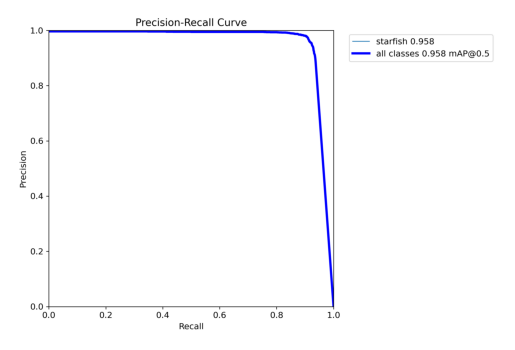

In [33]:
# plots results for yolov8l

rec_pre = Image.open(r"./runs/detect/train - v8 - optim/PR_curve.png")
fig, ax = plt.subplots()
ax.imshow(rec_pre)
ax.axis('off')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.show()

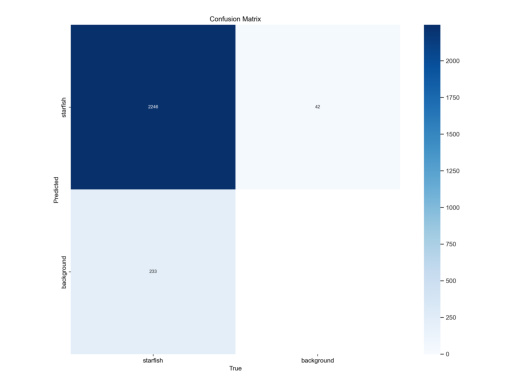

In [34]:
conf_mat = Image.open(r"./runs/detect/train - v8 - optim/confusion_matrix.png")
fig, ax = plt.subplots()
ax.imshow(conf_mat)
ax.axis('off')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.show()

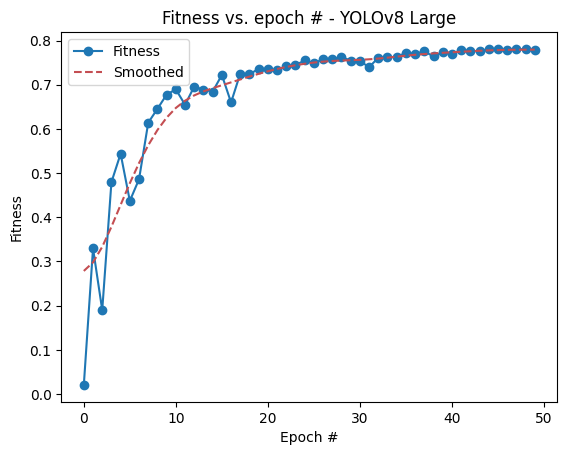

In [39]:
results_l = pd.read_csv(r"./runs/detect/train - v8 - optim/results.csv")
recall = results_l[results_l.axes[1][5]] 
map50 = results_l[results_l.axes[1][6]]
map5095 = results_l[results_l.axes[1][7]]
fitness_l = 0.2 * recall + 0.2 * map50 + 0.6 * map5095
fitness_smoothed_l = gaussian_filter1d(fitness_l, sigma=3) # Create a smoothed version of the training process
plt.plot(fitness_l, "-o", label="Fitness")
plt.plot(fitness_smoothed_l, "r--", label="Smoothed")
plt.title("Fitness vs. epoch # - YOLOv8 Large")
plt.xlabel("Epoch #")
plt.ylabel("Fitness")
plt.legend()